# Introduction to the Complex Analysis

This is the complex analysis expanding on what is covered in the article posted on Medium.com. If you would like to know more about it click the link: [CRISP-DM Regression Analysis in Python](https://medium.com/p/ade4b74bdc85/edit)

# Data Handling

## Imports

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from helper import unzip_files
from helper import cleaning_dollar
from helper import cleaning_percent
from helper import AnalysisStatus
from helper import DummySplit
from helper import get_top_collinearity
from helper import vif
from helper import apply_regression_models
from helper import get_word_cloud
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
%matplotlib inline

plt.style.use('default')
sns.set()

# Preparing for Extract
---

In [2]:
# getting zip file name
data_zip = os.listdir('data')
data_zip

['calendar.csv', 'listings.csv', 'reviews.csv', 'seattle.zip']

In [3]:
# extracting datasets
file_names = unzip_files(data_zip)
file_names

calendar.csv already extracted!
listings.csv already extracted!
reviews.csv already extracted!


['calendar.csv', 'listings.csv', 'reviews.csv', 'seattle.zip']

# Extracting the Calendar Dataset
---

In [4]:
df_calendar = pd.read_csv('data\calendar.csv')

## Distribution of calendar features

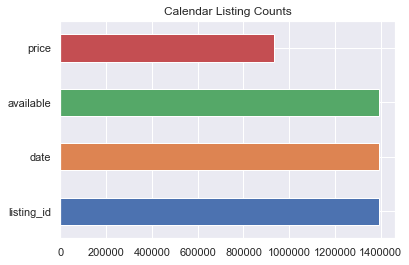

In [5]:
df_calendar.count().plot.barh(title="Calendar Listing Counts");

## Relationship Between Nulls Prices and Availability of Listing

In [6]:
df_calendar.assign(null_price=lambda x: (x.price.apply(type) == float)).groupby(
    ['available', 'null_price']).count()

,,listing_id,date,price
available,null_price,,,
f,True,459028,459028,0
t,False,934542,934542,934542


**Analysis:** Only price is missing values. However, we can notice that there is a relationship between the null values and the listing not being available. This suggests that all nulls are actually zero values.

# Extracting the Listings Dataset
---

In [7]:
df_listings = pd.read_csv('data\listings.csv')

## Distribution of listings features

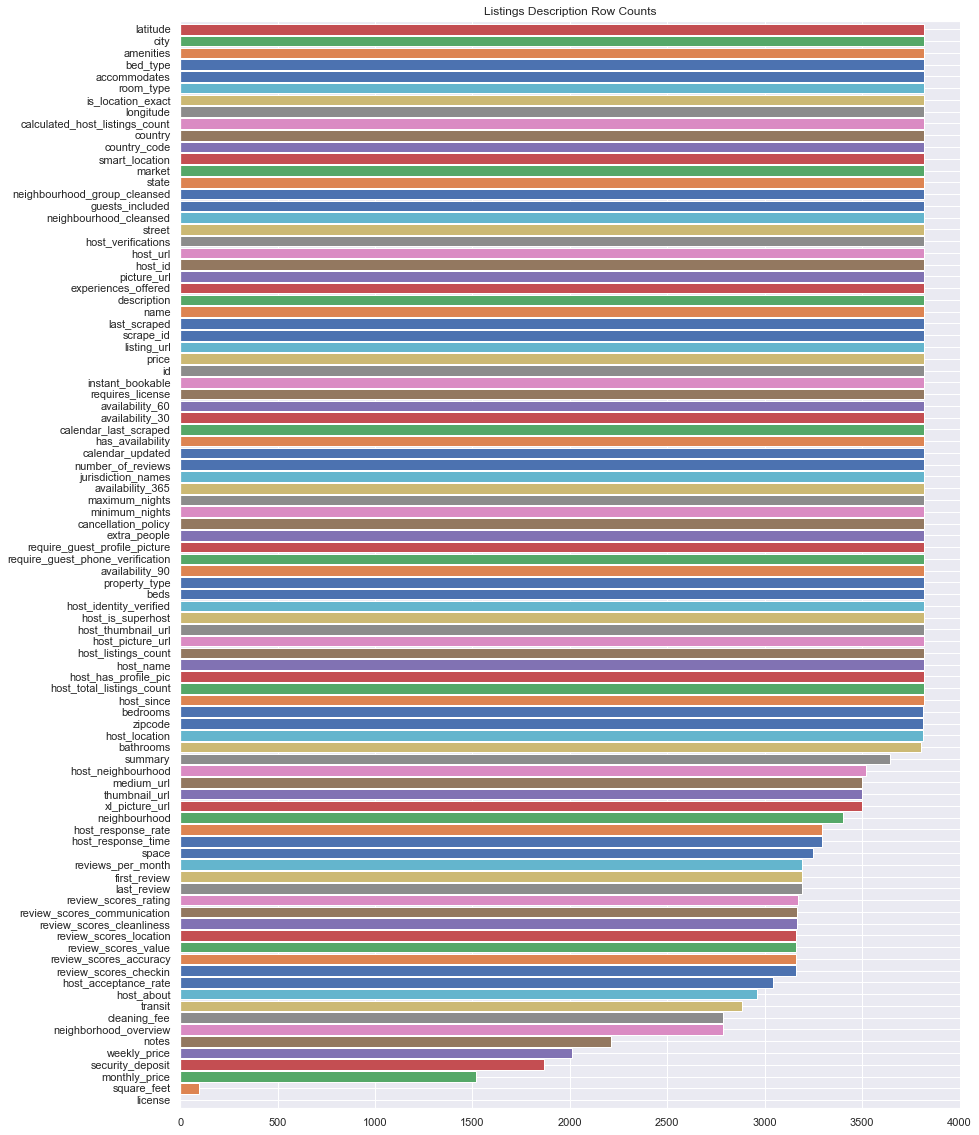

In [8]:
df_listings.count().sort_values().plot.barh(
    legend=False, 
    figsize=(14, 20), 
    rot=0, 
    width=.9,
    title="Listings Description Row Counts");

**Analysis**: We can quickly see features with extreme missing values that we should remove.

##  Distribution of listings Nulls

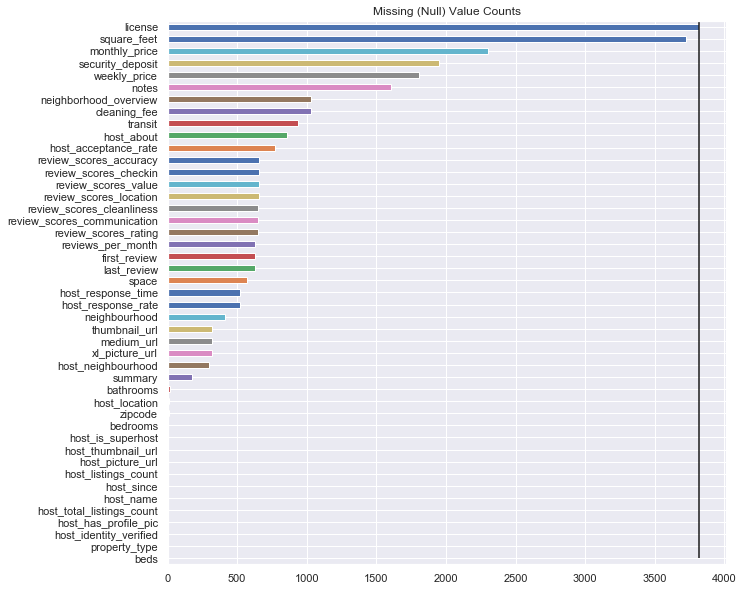

In [9]:
# Extracting only null counts
sr_listing_nulls = df_listings.isnull().sum().where(
    lambda x: x > 0).dropna(
    ).sort_values(ascending=True)

# Plotting the null counts
sr_listing_nulls.plot.barh(
    figsize=(10, 10), title="Missing (Null) Value Counts");
plt.vlines(df_listings.shape[0], 100, 0);

In [10]:
sr_extreme_null = (sr_listing_nulls/df_listings.shape[0]).where(
    lambda x: x>.90).dropna()
sr_extreme_null

square_feet    0.974594
license        1.000000
dtype: float64

**Analysis**: We can see that <mark><strong>license and squared_feet </strong></mark> have extreme nulled values. For this reason, we are removing them.

In [11]:
df_listings.drop(sr_extreme_null.index, axis=1, inplace=True)

# Extracting the Reviews Dataset
---

In [12]:
df_reviews = pd.read_csv('data/reviews.csv')

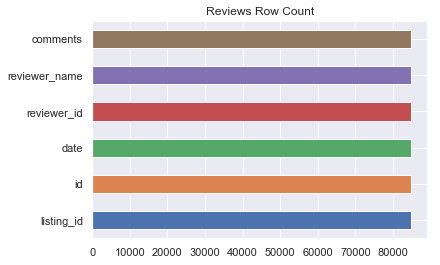

In [13]:
df_reviews.count().plot.barh(title="Reviews Row Count");

**Analysis**: Simple. Reviews are all complete.

# Understanding Calendar

##  First 5 Rows

In [14]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


##  Availability Counts

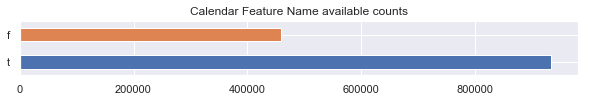

In [15]:
df_calendar.available.value_counts().plot.barh(
    figsize=(10, 1), 
    title='Calendar Feature Name available counts', 
    legend=False);

##  Price Formats

In [16]:
df_calendar.price.str.findall('\D').value_counts().to_frame('price_counts')

,price_counts
"[$, .]",933845
"[$, ,, .]",697


In [17]:
# type of date
df_calendar.date.apply(type).unique()

array([<class 'str'>], dtype=object)

**Analysis**: We will need to clean these invalid characters from the prices. And we need to convert string dates to datetime.

In [18]:
# Cleaning prices
df_calendar.price = cleaning_dollar(df_calendar.price)

# Converting date to datetime
df_calendar.date = pd.to_datetime(df_calendar.date)

In [19]:
# Validating price conversion
df_calendar.price.apply(type).unique()

array([<class 'float'>], dtype=object)

In [20]:
# type of date conversion
df_calendar.date.apply(type).unique()

array([<class 'pandas._libs.tslibs.timestamps.Timestamp'>], dtype=object)

## Price Line Trends by Dataset Source

### Aggregate Price Trend with Filtered Nulls

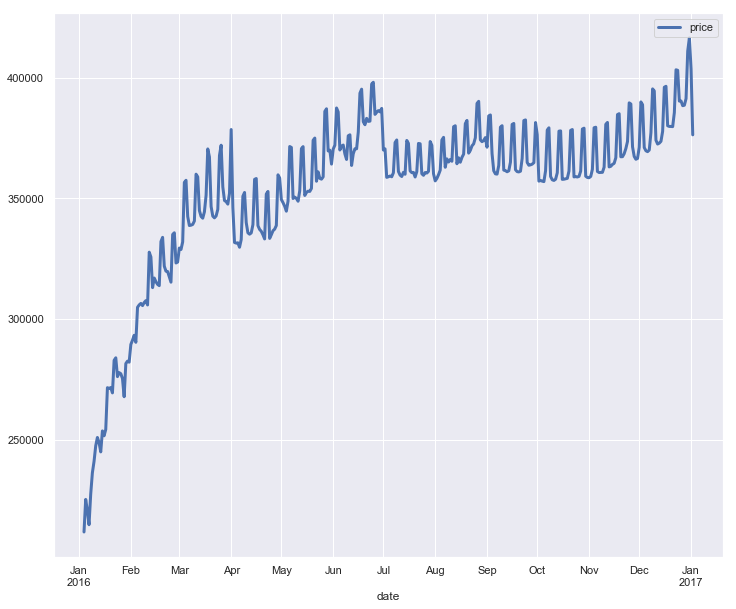

In [21]:
df_calendar.groupby(['date']).agg({'price':'sum'}).plot.line(
    figsize=(12, 10), lw=3);

In [22]:
df_calendar.date.describe()

count                 1393570
unique                    365
top       2016-12-27 00:00:00
freq                     3818
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

In [23]:
df_calendar.assign(
    month=lambda x: x.date.dt.to_period("M")
    ).month.value_counts()

2016-03    118358
2016-05    118358
2016-07    118358
2016-12    118358
2016-08    118358
2016-10    118358
2016-04    114540
2016-06    114540
2016-11    114540
2016-09    114540
2016-02    110722
2016-01    106904
2017-01      7636
Freq: M, Name: month, dtype: int64

**Analysis**: Seattle seem to have been serviced for the first time in January 2016. And the last month seem to be an incomplete month--with only 2 days of the month provided.

### Price Trend with Zeroed Nulls

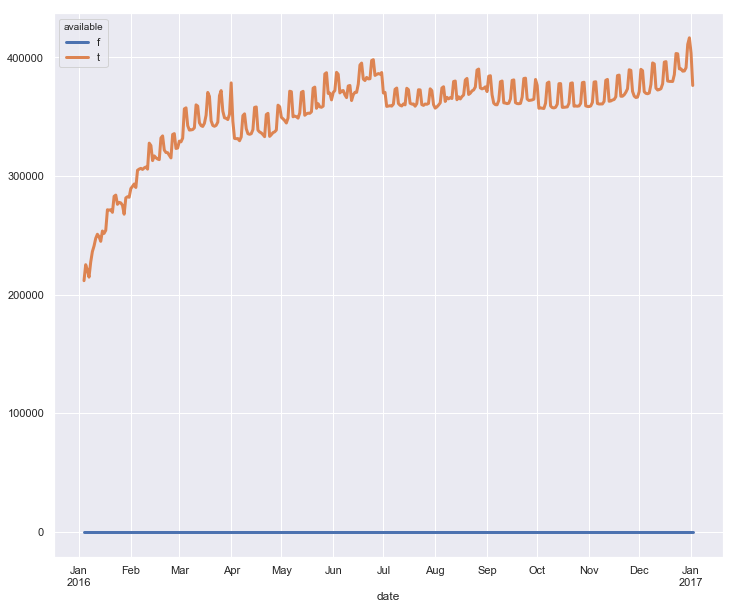

In [24]:
df_calendar.fillna(0).groupby(['date', 'available']).agg(
        {'price':'sum'}
    ).reset_index().pivot(
        index='date', 
        columns='available', 
        values='price').plot.line(
    figsize=(12, 10), lw=3);

**Analysis**: Null values ranges from start to end. We can safely assume this is normal and these values are actually $0 because they are not listed. <mark><strong>We are removing unavailable listings. Since the rest of the available lables are just t, we are removing the columns.

In [25]:
df_calendar = df_calendar.query("available=='t'")

In [26]:
df_calendar.drop('available', axis=1, inplace=True)

# Understanding Listings
---

## Analyzing Object Features of Listings

In [27]:
# Calculating missing percentages of total listings
missing_pct = df_listings.isnull().sum() / df_listings.shape[0]

# Listings examples with missing percentages
pd.options.display.max_rows = 100

df_listings.select_dtypes(include=object).dropna(
    axis=0, how='all').sample(1).T.merge(
        missing_pct.to_frame('missing'),
        left_index=True,
        right_index=True,
        how='left').iloc[:, [1, 0]].sort_values(
            'missing', ascending=False).style.bar()

,missing,3249
monthly_price,0.602672,$895.00
security_deposit,0.511262,$95.00
weekly_price,0.473808,$350.00
notes,0.420639,nan
neighborhood_overview,0.270299,nan
cleaning_fee,0.269775,nan
transit,0.244631,nan
host_about,0.224987,"Hi, I am the host at Maple Creek House in Wedgwood. I am a writer and artist. A Seattle native, I enjoy sharing my enthusiasm for our lovely natural areas and charming city. It is fun to meet folks from all over the world as they visit and study here. This is a great place for outdoor photography walks too."
host_acceptance_rate,0.202462,100%
first_review,0.164222,2010-09-26


**Analysis**: We can see some irrelevant features such as urls and names. 

## Analying Numeric Features of Listings

In [28]:
df_listings.select_dtypes(exclude=object).sample(4).T.merge(
    missing_pct.to_frame('missing'),
    left_index=True,
    right_index=True,
    how='left').iloc[:, [-1, 0, 1, 2, 3]].sort_values(
        'missing',
        ascending=False).style.format("{:2,.2f}").bar(subset=['missing'])

,missing,3101,1289,1272,526
review_scores_checkin,0.17,10.00,nan,10.00,nan
review_scores_accuracy,0.17,10.00,nan,10.00,nan
review_scores_value,0.17,9.00,nan,9.00,nan
review_scores_location,0.17,10.00,nan,10.00,nan
review_scores_cleanliness,0.17,10.00,nan,10.00,nan
review_scores_communication,0.17,10.00,nan,10.00,nan
review_scores_rating,0.17,95.00,nan,97.00,nan
reviews_per_month,0.16,0.67,nan,0.69,nan
bathrooms,0.00,1.00,1.00,2.00,2.00
bedrooms,0.00,1.00,1.00,2.00,2.00


**Analysis**: There is a few missing values in the review features, bedrooms, and bathrooms. The ids are not going to be usefull to the model.

## Analyzing Date Features of Listings

In [29]:
df_listings.select_dtypes(include=object)\
    .apply(pd.to_datetime, errors='ignore')\
    .select_dtypes(include=np.datetime64).head()

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
0,2016-01-04,2011-08-11,2016-01-04,2011-11-01,2016-01-02
1,2016-01-04,2013-02-21,2016-01-04,2013-08-19,2015-12-29
2,2016-01-04,2014-06-12,2016-01-04,2014-07-30,2015-09-03
3,2016-01-04,2013-11-06,2016-01-04,NaT,NaT
4,2016-01-04,2011-11-29,2016-01-04,2012-07-10,2015-10-24


In [30]:
# Unique values for last_scraped and calendar_last_scraped
df_listings.groupby(['last_scraped', 'calendar_last_scraped']).size()

last_scraped  calendar_last_scraped
2016-01-04    2016-01-04               3818
dtype: int64

**Analysis**: We can see that we have to do some imputations on the reviews for the numerical fields. For the object fields, there are some numerical values that will have to be cleaned and some irrelevant columns such as URLs and names. One thing to notice is that **amenities** and **host_verification** can be split and converted to dummy variables. These features could be helpful to the model.

<mark>Perhaps the **calendar_last_scraped** feature has a meaningful link to the dataset. It means the same as **last_scraped**, so we are only keeping one.</mark> The other dates (**first_review, host_since, and last_review**) could be used to engineer new features. 

In [31]:
df_listings.drop('last_scraped', axis=1, inplace=True)

# Uderstanding Reviews

##  Frist 5 Rows

In [32]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## Id Relationships Lenght Box Plots

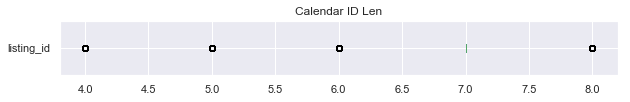

In [33]:
df_calendar.listing_id.astype(str).str.len()\
    .plot.box(vert=False, figsize=(10, 1), title="Calendar ID Len");

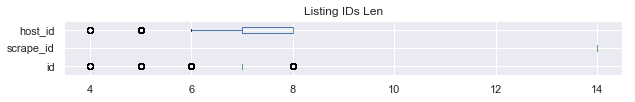

In [34]:
len_func = lambda x: x.str.len()

df_listings.filter(regex='id').select_dtypes(exclude=object).astype(str).apply(len_func)\
    .plot.box(vert=False, figsize=(10, 1), title="Listing IDs Len");

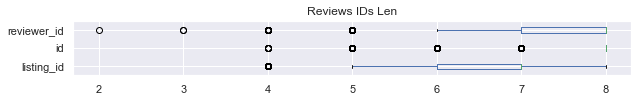

In [35]:
df_reviews.filter(regex='id').apply(lambda x: x.astype(str).str.len())\
    .plot.box(vert=False, figsize=(10, 1), title="Reviews IDs Len");

**Analysis**: From all ids, we can see the listing_id and id are the ones to use to merge the datasets. <mark>The other ids are irrelevant to the analysis. So we will delete them.

In [36]:
df_listings.drop(['host_id', 'scrape_id'], axis=1, inplace=True)

# Calendar Granularity

## Calendar Duplicates

In [37]:
df_calendar.head()

,listing_id,date,price
0,241032,2016-01-04,85.0
1,241032,2016-01-05,85.0
9,241032,2016-01-13,85.0
10,241032,2016-01-14,85.0
14,241032,2016-01-18,85.0


In [38]:
df_calendar.duplicated(subset=['listing_id', 'date']).sum()

0

**Analysis**: There are no duplicates in the calendar dataset. So for now, it is valid.

# Listings Granularity

## First 5 Rows

In [39]:
df_listings.head(2)

,id,listing_url,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,...,9.0,10.0,f,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",...,10.0,10.0,f,WASHINGTON,f,strict,t,t,6,1.48


## Listings Duplicates

In [40]:
df_listings.duplicated(subset=['id']).sum()

0

**Analysis**: There are no duplicates in the listings dataset. So for now, it is valid.

# Reviews Granularity

## First 5 Rows

In [41]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## Reviews Duplicates

In [42]:
df_reviews.duplicated('id').sum()

0

**Analysis**: There are no duplicates in the reviews dataset. So for now, it is valid.

## Multiple Comments by Reviewer Relating to Listings

In [43]:
df_reviews.groupby(
        ['listing_id', 'reviewer_id', 'date']
    ).size().to_frame("duplicates").query("duplicates>1").reset_index()

,listing_id,reviewer_id,date,duplicates
0,447523,35607120,2015-07-06,2
1,3533224,39668556,2015-12-01,2


**Analysis**: There are two listings with multiple comments on the same date and same reviewer.

In [44]:
df_reviews.query(
    """reviewer_id==['35607120', '39668556']\
        and listing_id==['447523', '3533224']
    """)

,listing_id,id,date,reviewer_id,reviewer_name,comments
16387,3533224,55354340,2015-12-01,39668556,Iris,"Michael is a good host,He was not at home when..."
16388,3533224,55554854,2015-12-01,39668556,Iris,非常好
29086,447523,37438229,2015-07-06,35607120,Mary Ellen,The host canceled this reservation 47 days bef...
29087,447523,37438231,2015-07-06,35607120,Mary Ellen,The host canceled this reservation 53 days bef...


**Analysis**: However, as it relates to listings, there are several reviews for the same listing during the same date. Some of them have automated comments that could be impacting the overall listing reviews.

# Testing Relationships beteween Datasets

## Relationship between Geo Columns

In [45]:
list_geo_cols = ['host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed'
                    'neighbourhood_group_cleansed', 'city', 'state', 'market', 'country',
                    'host_location', 'jurisdiction_names']

In [46]:
df_listings.sample(4).T.query(f"index=={list_geo_cols}")

,572,2088,525,2003
host_location,"Seattle, Washington, United States","Seattle, Washington, United States","Seattle, Washington, United States","Seattle, Washington, United States"
host_neighbourhood,NaN,North Beacon Hill,Green Lake,Greenwood
neighbourhood,NaN,North Beacon Hill,Green Lake,Greenwood
city,Seattle,Seattle,Seattle,Seattle
state,WA,WA,WA,WA
market,Seattle,Seattle,Seattle,Seattle
country,United States,United States,United States,United States
jurisdiction_names,WASHINGTON,WASHINGTON,WASHINGTON,WASHINGTON


**Analysis**: It is obvious the country of interest is United States, the market is Seattle, and the state is Washington, so we don't need **country, market, and state**.

In [47]:
df_listings.drop(['country', 'market', 'state'], axis=1, inplace=True)

In [48]:
df_listings.city.value_counts()

Seattle                  3810
Seattle                     2
West Seattle                2
seattle                     1
西雅图                         1
Ballard, Seattle            1
Phinney Ridge Seattle       1
Name: city, dtype: int64

**Analysis**: The problem with city is the sparsity of it. Almost all of the classes are grouped in Seattle leaving almost no listings outside of the other segments of the city. <mark>We need to remove **city**.

In [49]:
list_other_geo = ['host_location', 'host_neighbourhood', 'neighbourhood',
                 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
                  'jurisdiction_names', 'city']
df_listings[list_other_geo].nunique()

host_location                   120
host_neighbourhood              102
neighbourhood                    81
neighbourhood_cleansed           87
neighbourhood_group_cleansed     17
jurisdiction_names                1
city                              7
dtype: int64

**Analysis**: The rest of the geographical features are too sparse, which can create problems in the model. <mark>So we are deleting **host_location, host_neighbourhood, and neighbourhood**.

In [50]:
df_listings.drop(list_other_geo, axis=1, inplace=True)

## Looking for Meaningful Relationship Between Listing and Reivews

### Assessing Reviews and Ids from Sample

In [51]:
# Assessing duplicate id in listings again
print("There are" , 
      df_listings.id.value_counts().where(lambda x: x>1).sum(),
      "dupliate ids in the listing dataset.")

There are 0.0 dupliate ids in the listing dataset.


In [52]:
airbnb_review_test = df_listings.merge(
    df_reviews, 
    left_on='id', 
    right_on='listing_id', 
    how='left', 
    suffixes=['', '_review'],
    indicator=True)

In [53]:
airbnb_review_test.duplicated(subset=['id']).sum()

81658

In [54]:
airbnb_review_test.groupby('id').size().to_frame('dup').query("dup>1").head()

,dup
id,
4291,35
5682,297
6606,52
7369,40
9419,79


**Analysis**: There are many comments per listing that could help to determine the missing reviews.

### Descriptive Statistics About Comments

In [55]:
comment_listing_counts = df_reviews.groupby('listing_id').size().to_frame(
    'comment_count').groupby('comment_count').size().reset_index().rename(
        columns={0: 'total_unique_listing_ids'})

comment_listing_counts[['comment_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
comment_count,194.0,113.592784,86.824904,1.0,49.25,97.5,154.75,474.0


In [56]:
comment_listing_counts.groupby(
    pd.cut(comment_listing_counts.comment_count,
           bins=list(np.arange(0, 550, 50)))).sum()[[
               'total_unique_listing_ids'
           ]].reset_index().set_index('total_unique_listing_ids').rename(
               columns={'comment_count': 'comment_count_buckets'})

,comment_count_buckets
total_unique_listing_ids,
2711,"(0, 50]"
320,"(50, 100]"
96,"(100, 150]"
35,"(150, 200]"
13,"(200, 250]"
10,"(250, 300]"
2,"(300, 350]"
1,"(350, 400]"
1,"(400, 450]"


**Analysis**: We can see that most listings have from 1 to 50 comments to apply natural language processing to predict ratings in the listing dataset if needed. 

The relationship between listing dataset reviews and reviews dataset comments is by the listing_id there are at most 474 reviews on at least one listing. Two listings have around 451 to 474 comments. However, the majority of the listings have 1 to 50 comments. So for some listing_ids predicting ratings might be difficult due to low proportions.

# Preparing Data for Analysis

## Converting dates to ordinal ranks

In [57]:
# column additions for scatter and monthly comparisons
df_calendar_clean = df_calendar.assign(date_num=lambda x: x.date.rank(method='dense'))

## Finishing Calendar Data

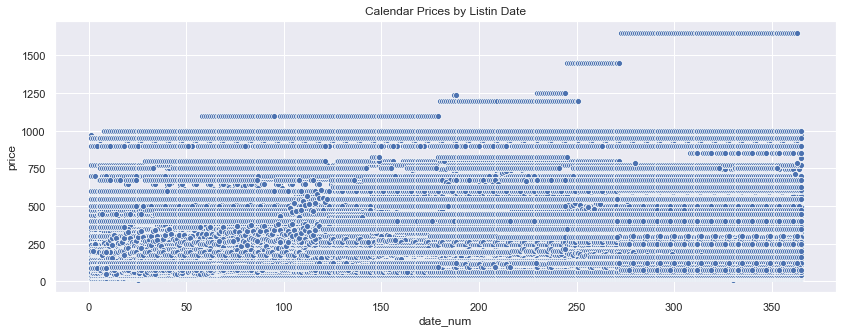

In [58]:
plt.figure(figsize=(14, 5))
plt.title('Calendar Prices by Listin Date');
sns.scatterplot(x='date_num', 
                y='price', 
                data=df_calendar_clean);

### Removing Irrelevant Columns and Date Saving References

In [59]:
# Save date and date number for reference
df_date_references = df_calendar_clean[['date', 'date_num']]

# Removing dates
df_calendar_clean.drop('date', axis=1, inplace=True)

# Calendar done
df_calendar_complete = df_calendar_clean.copy()
del df_calendar_clean

### Checking Correlations of Final Calendar

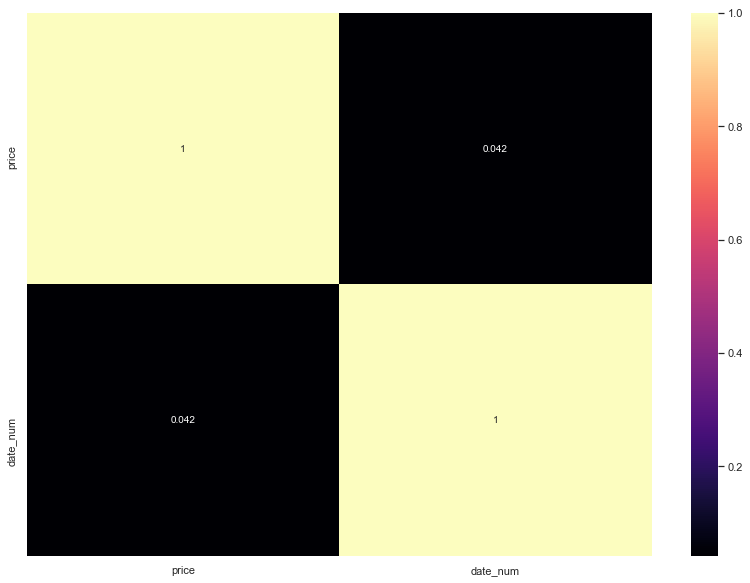

In [60]:
analysis = AnalysisStatus(df_calendar_complete, df_listings)
analysis.correlation_heatmap(['date_num'])

**Analysis**: Good. Alone with price, the date number has at least a low correlation with price, which means that there is  $𝑟^2$  percentage of explanation by daily movements. The rest can be attributed to other features that we are going to explore next.

## Listing Removals or Imputations

### Listings Null Analysis

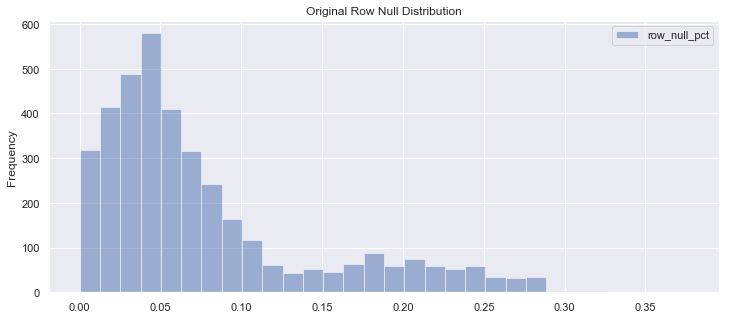

In [61]:
analysis.null_row_listingdist(30, 'Original Row Null Distribution')               

**Analysis**: We are not observing an alarming rate of rows with null values across it. However, some of these features might be irrelevant for the analysis, and we should remove them. There could be other variables that can be impute. We will assess this distribution again after removals and imputations.

### Identifying Irrelevant Columns

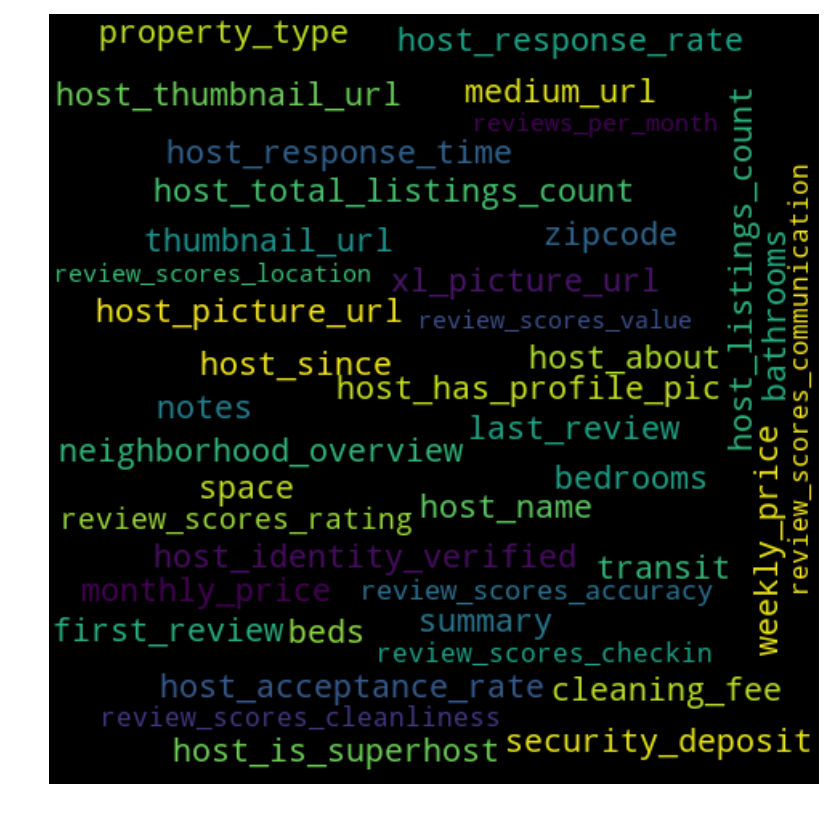

In [65]:
# target colmuns for imputations and transformations
target_columns = df_listings.isnull().sum().where(lambda x: x>0).dropna().index.tolist()

get_word_cloud(target_columns)

**Note**: All of these features in the wordcloud need to be analyized for null relations to other feature values. But some of theme are irrelevant for the analysis such as those that finish with url.

### Columns to Remove due to Irrelevance

In [66]:
# Irrelevant columns
list_irrelevant_cols = df_listings.columns.str.contains('url|name|about|pic')
list_irrelevant_cols = df_listings.columns[list_irrelevant_cols].tolist()

# Show irrelevant features
df_listings[list_irrelevant_cols].head(1).T.style.set_caption("Irrelevant Features")

,0
listing_url,https://www.airbnb.com/rooms/241032
name,Stylish Queen Anne Apartment
thumbnail_url,nan
medium_url,nan
picture_url,https://a1.muscache.com/ac/pictures/67560560/cfe47d69_original.jpg?interpolation=lanczos-none&size=large_cover&output-format=jpg&output-quality=70
xl_picture_url,nan
host_url,https://www.airbnb.com/users/show/956883
host_name,Maija
host_about,"I am an artist, interior designer, and run a small landscape business. My life revolves around beauty wherever I find it or create it. I grew up in Seattle and love this city for the people, it's natural beauty and don't know anywhere else I would rather call home. I love to travel and try to do so as much as possible and am excited to be a part of the airbnb community!"
host_thumbnail_url,"https://a0.muscache.com/ac/users/956883/profile_pic/1318103129/original.jpg?interpolation=lanczos-none&crop=w:w;*,*&crop=h:h;*,*&resize=50:*&output-format=jpg&output-quality=70"


**Analysis**: These, above, are irrelevant columns since they describe web addresses and names. So there is no value to them in a regression analysis. 

On the contrary **host_has_profile_pic** and **require_guest_profile_picture** might add value to the model.

### Null Row Values Exceeding 10%

In [67]:
analysis.null_row_feature_status(percentages=True, threshold=.10)

monthly_price                  0.602672
security_deposit               0.511262
weekly_price                   0.473808
notes                          0.420639
neighborhood_overview          0.270299
cleaning_fee                   0.269775
transit                        0.244631
host_about                     0.224987
host_acceptance_rate           0.202462
review_scores_checkin          0.172342
review_scores_accuracy         0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
reviews_per_month              0.164222
first_review                   0.164222
last_review                    0.164222
space                          0.149031
host_response_time             0.136983
host_response_rate             0.136983
dtype: float64

### Assessing Transformations of Informational Features

#### Examples of Informational Columns with Missing Values

In [68]:
iform_arguments = 'access|over|rule|notes|space|summary|transit|interaction|host_about|desc'
list_inform_cols = df_listings.filter(regex=iform_arguments).columns.tolist()
df_listings[list_inform_cols].head()

,summary,space,description,neighborhood_overview,notes,transit,host_about
0,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,"I am an artist, interior designer, and run a s..."
1,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",Living east coast/left coast/overseas. Time i...
2,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,i love living in Seattle. i grew up in the mi...
3,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,NaN
4,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,"Hi, I live in Seattle, Washington but I'm orig..."


**Analysis**: All of these features provide information about the listing. The imputation logic is to provide indicators where the information was provided (1) and not provided (0).

In [69]:
# Values with 1 should match this
df_listings[list_inform_cols].isnull().sum()

summary                   177
space                     569
description                 0
neighborhood_overview    1032
notes                    1606
transit                   934
host_about                859
dtype: int64

**Sanity Check**: We are validating informational transformations to these null value counts.

In [70]:
# listings checkpoint
df_listings_transform = df_listings.copy()

In [71]:
# creating the new column for provided access information
df_listings_transform.loc[:, list_inform_cols] = df_listings[
    list_inform_cols].where(
    lambda x: x.isnull(), 0).fillna(1)

In [72]:
# Matching 1 to provided information
df_listings_transform[list_inform_cols].sum()

summary                   177
space                     569
description                 0
neighborhood_overview    1032
notes                    1606
transit                   934
host_about                859
dtype: int64

**Sanity Check**: Tranformation checks out.

#### Checking Correlations of Informational Features

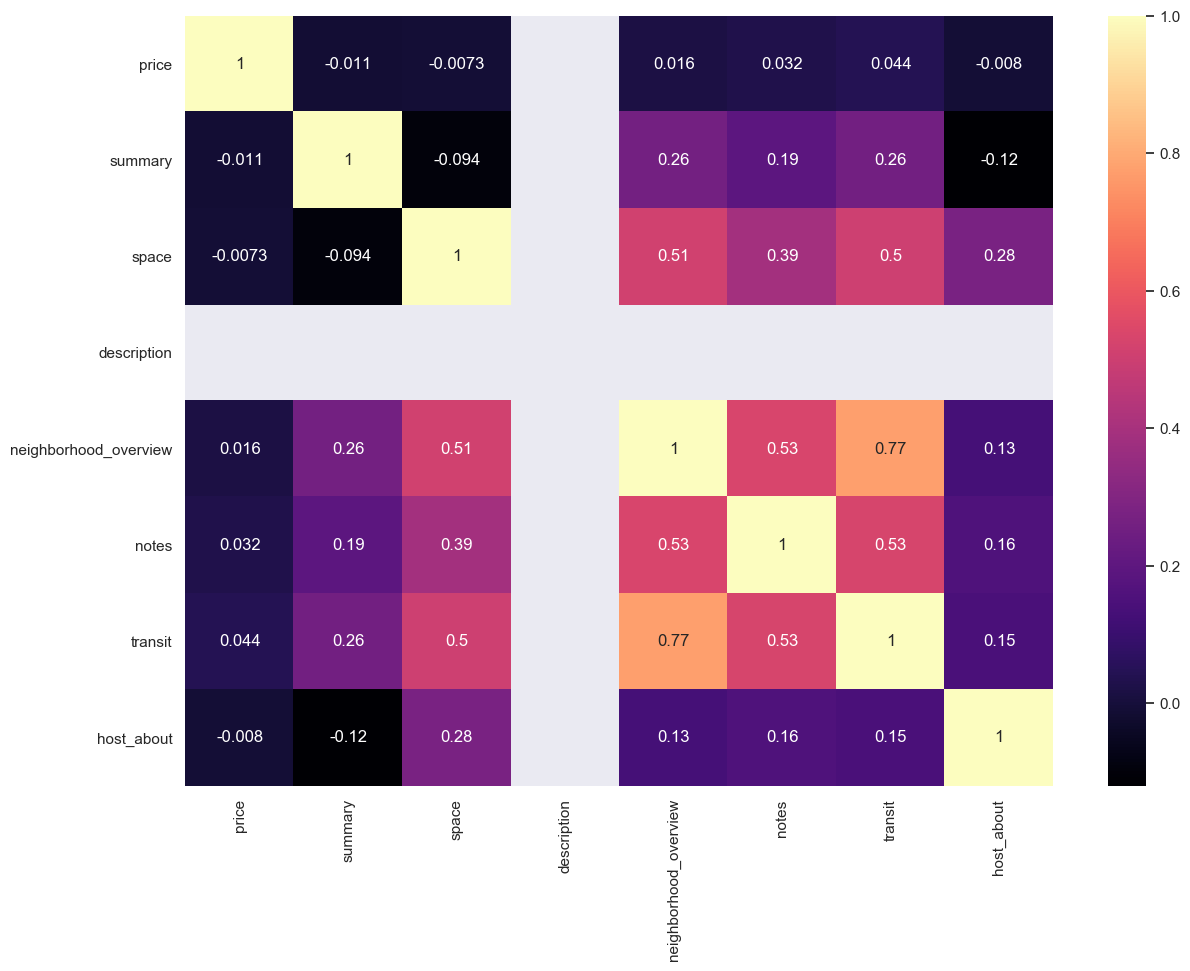

In [73]:
analysis = AnalysisStatus(df_calendar_complete, df_listings_transform)
analysis.correlation_heatmap(list_inform_cols)

In [74]:
df_listings.description.isnull().sum()

0

In [75]:
df_listings_transform.description.value_counts()

0    3818
Name: description, dtype: int64

**Analysis**: Correlations ended up not being valuable to a linear model. However, perhaps these features can be beneficial for a random forest regression model. However, descriptions were completely populated and therefore, <mark> the dummy approach to impute for nulls is not valid. So we will remove it.

In [76]:
df_listings_transform.drop('description', axis=1, inplace=True)

In [77]:
list_linear_features = ['date']
list_forest_features = list_inform_cols

#### Checking Null Distributions After Transformations

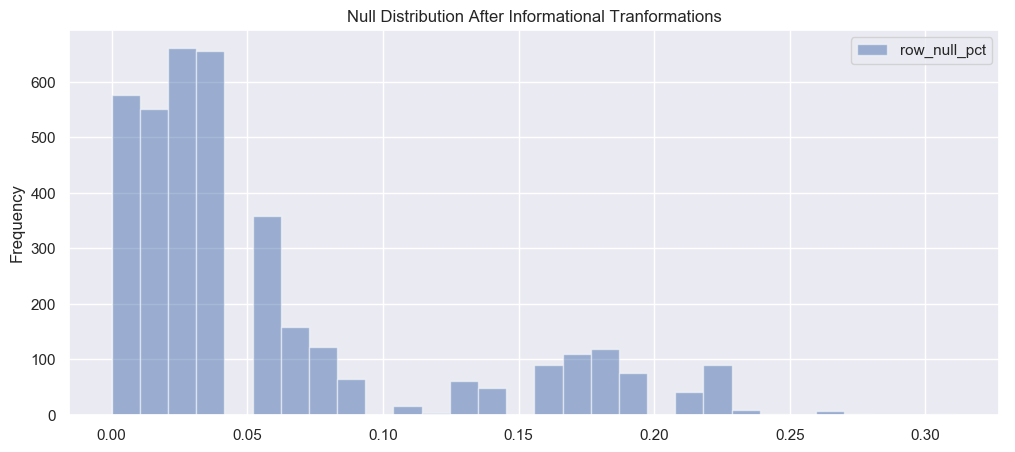

In [78]:
analysis.null_row_listingdist(
    bins=30, title='Null Distribution After Informational Tranformations')

**Analysis**: The distribution of nulls is much cleaner now, and we still have not done any row 
removals in the listings dataset.

### Assessing Dolar Value Features

In [79]:
# Preparing for tranformations
list_dollar_cols = df_listings_transform.filter(regex='fee|price|deposit|extra').columns.tolist()

# Cleaning all dollar features
df_listings_transform.loc[:, list_dollar_cols] = df_listings_transform[
    list_dollar_cols].apply(cleaning_dollar)

#### Checking Correlations for Dollar Features

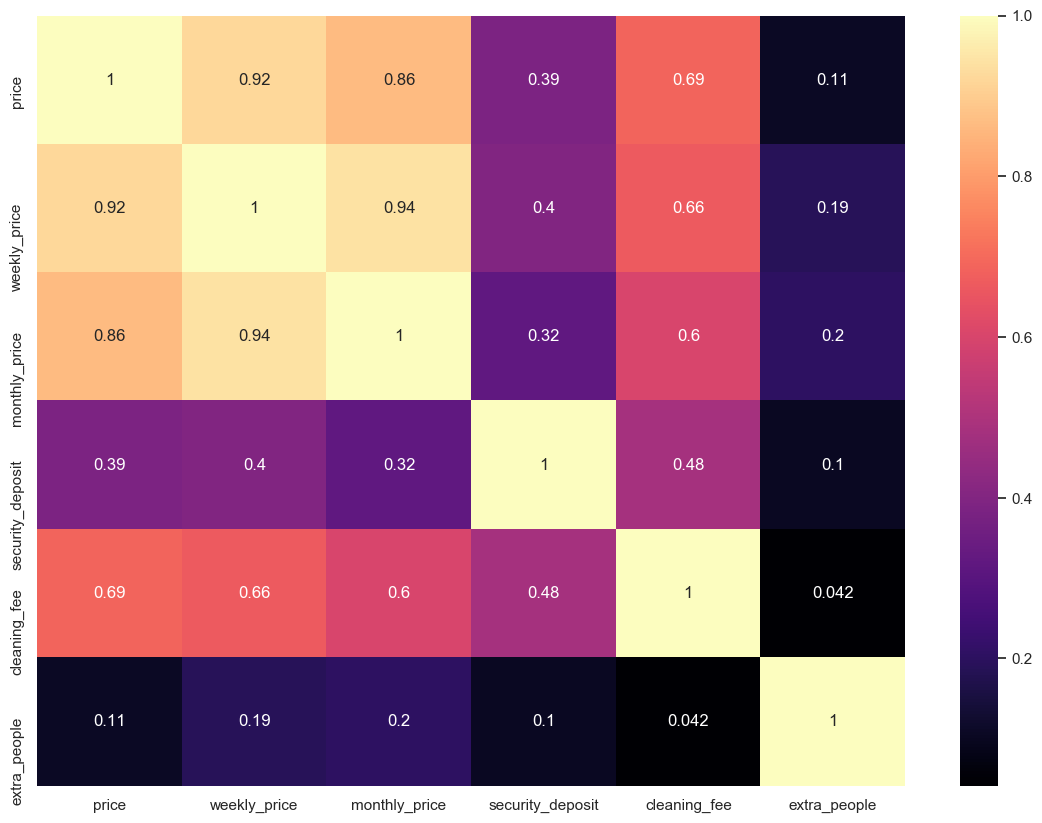

In [80]:
analysis = AnalysisStatus(df_calendar_complete, df_listings_transform)
analysis.correlation_heatmap(list_dollar_cols)

**Analysis**: We can see that monthly price is highly correlated with price. But these two variables are linking variables, which means that manipulating one will manipulate the other one dependently. Therefore, **monthly_price** is not independent. We must remove it. The same applies to **weekly_price**.

So there is no use for using **monthly_price** and **weekly_price** to predict price because that is a bit redundant--no wonder they are heavily correlated. However, **cleaning_fee, extra_people, and security_deposit** are the main drivers of the listing price. Thus, we are dropping listing price derived features and keeping the fees, which are additions to the price.

In [81]:
df_listings_transform.drop(['monthly_price', 'weekly_price'], axis=1, inplace=True)

#### Imputations of Zero Fees and Deposits

In [82]:
fee_columns = ['cleaning_fee', 'security_deposit', 'extra_people']
df_listings_transform.loc[:, fee_columns] = df_listings_transform[fee_columns].fillna(0)

**Analysis**: We are assuming all null cleaning fees are zero fees.

#### Checking Null Distributions After Removal of Pricing Derived Features and Imputations

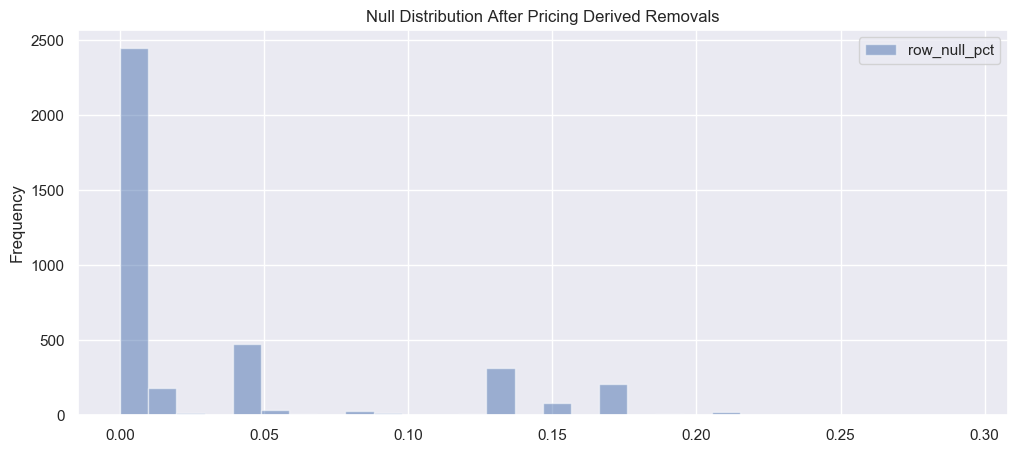

In [83]:
analysis.null_row_listingdist(
    bins=30, title='Null Distribution After Pricing Derived Removals')

**Analysis**:It is looking very clean now. But we still have more work to do--more cleaning.

In [84]:
analysis.null_row_feature_status(percentages=True)

host_acceptance_rate           0.202462
review_scores_checkin          0.172342
review_scores_accuracy         0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
reviews_per_month              0.164222
last_review                    0.164222
first_review                   0.164222
host_response_time             0.136983
host_response_rate             0.136983
dtype: float64

#### Assessing Has Availability Feature

In [85]:
# number of zero prices
df_listings_transform.query("has_availability!=has_availability").price.where(
    lambda x: x == 0).dropna()

Series([], Name: price, dtype: float64)

**Analysis**: As we know available listings have prices. All listings have prices in the listings dataset. Therefore, has_availability should all be True. In this case, this feature provides no value to the model, and we will remove it.

In [86]:
df_listings_transform.drop('has_availability', axis=1, inplace=True)

### Assessing Reviews

#### Reviews where Number of Reviews where not Zero

In [87]:
# Columns related to reviews
list_review_cols = df_listings_transform.columns[
    df_listings_transform.columns.str.contains('review')]
list_review_cols = ['id'] + list_review_cols.tolist()

df_listings_transform[list_review_cols].query(
    "number_of_reviews!=0").isnull().sum().to_frame('missing')

,missing
id,0
number_of_reviews,0
first_review,0
last_review,0
review_scores_rating,20
review_scores_accuracy,31
review_scores_cleanliness,26
review_scores_checkin,31
review_scores_communication,24
review_scores_location,28


**Analysis**: Where the numer of reviews are not zero there are minimal null values that can be drop from the model, or just converted to the median rating for now.

#### Reviews where Number of Reviews where Zero

In [88]:
df_listings_transform[list_review_cols].query(
        "number_of_reviews==0").isnull().sum(
    ).to_frame('missing')

,missing
id,0
number_of_reviews,0
first_review,627
last_review,627
review_scores_rating,627
review_scores_accuracy,627
review_scores_cleanliness,627
review_scores_checkin,627
review_scores_communication,627
review_scores_location,627


**Analysis**: All of these values have a meaning of no rating provided. Therefore, we should not remove any of these. We are going to impute the median score for all of the missing scores as of now.

#### Reviews where Number of Reviews where not Zero Including Reviews Dataset Merge

In [89]:
df_listings_transform[list_review_cols].query("number_of_reviews!=0").merge(
    df_reviews.groupby('listing_id', as_index=False).sum(),
    left_on='id',
    right_on='listing_id',
    how='left',
    suffixes=['', '_reviews']).isnull().sum().to_frame('missing')

,missing
id,0
number_of_reviews,0
first_review,0
last_review,0
review_scores_rating,20
review_scores_accuracy,31
review_scores_cleanliness,26
review_scores_checkin,31
review_scores_communication,24
review_scores_location,28


**Analysis**: There are comment that we could use to extract ratings using NLP. However, the extra work might not provide us the accuracy that we deserve given that there is so few missing ratings. The median will do for these.

#### Imputing Scores

In [90]:
# Instantiating imputer
simp_imp = SimpleImputer(missing_values=np.nan, strategy='median')

# Imputing Scores
df_scores = df_listings_transform.filter(regex='score')
scores_cols = df_scores.columns
array_scores = simp_imp.fit_transform(df_scores)

# Assigning imputed scores
df_listings_transform.loc[:, scores_cols] = pd.DataFrame(array_scores, columns=scores_cols)

#### Imputing Revie Dates and Reviews per Month

In [91]:
review_cols = df_listings_transform.filter(regex='per_m|first_rev|last_rev').columns

# Imputations
df_listings_transform.loc[:, review_cols] = df_listings_transform[review_cols].fillna(0)

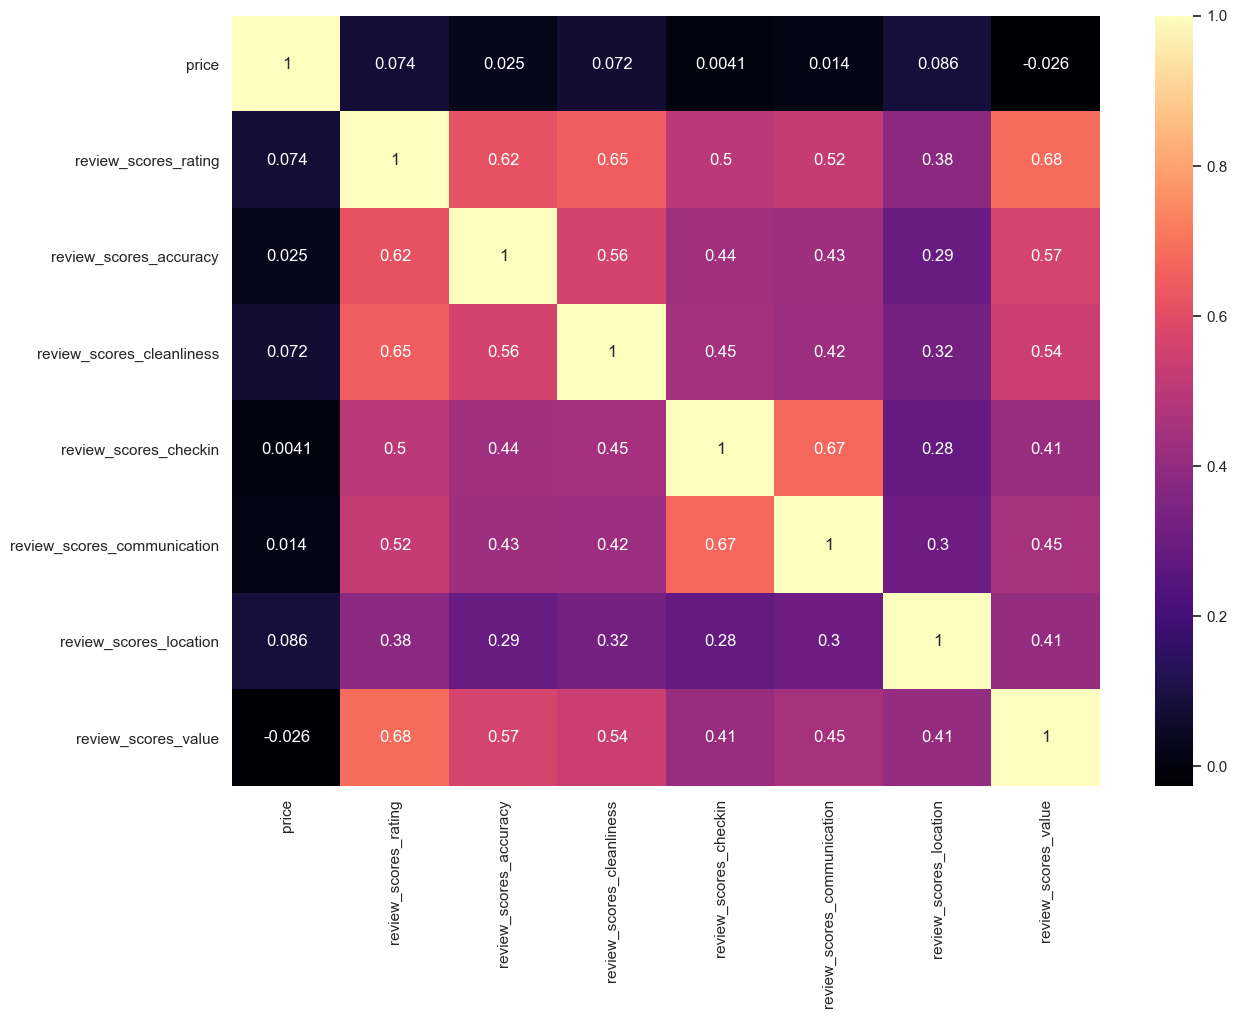

In [92]:
analysis = AnalysisStatus(df_calendar_complete, df_listings_transform)
analysis.correlation_heatmap(scores_cols.tolist())

**Analysis**: We can see that scores bring no value to the linear model. Therefore, they will not be tested in the linear model, but they will be included in the ensemble model to thest them.

In [93]:
list_forest_features = list_forest_features + scores_cols

####  Engineering review_lag and review_rate

In [94]:
try:
    checkpoint
except:
    checkpoint = df_listings_transform.copy()

In [95]:
# creating the lag between first and last review
diff_func = lambda x: (pd.to_datetime(x.last_review) - pd.to_datetime(x.first_review)).dt.days
reate_func = lambda x: (x.review_lag / x.number_of_reviews)

# engineering review lag
df_listings_transform = df_listings_transform.assign(review_lag=diff_func)

# engineering review rate
df_listings_transform = df_listings_transform.assign(review_rate_per_lifetime=reate_func)

# dropping fist_review and last_review
review_dates = ['first_review', 'last_review']
df_listings_transform.drop(review_dates, axis=1, inplace=True)

In [96]:
# Zero for no review provided
df_listings_transform.loc[
    :, 'review_rate_per_lifetime'] = df_listings_transform.review_rate_per_lifetime.fillna(0)

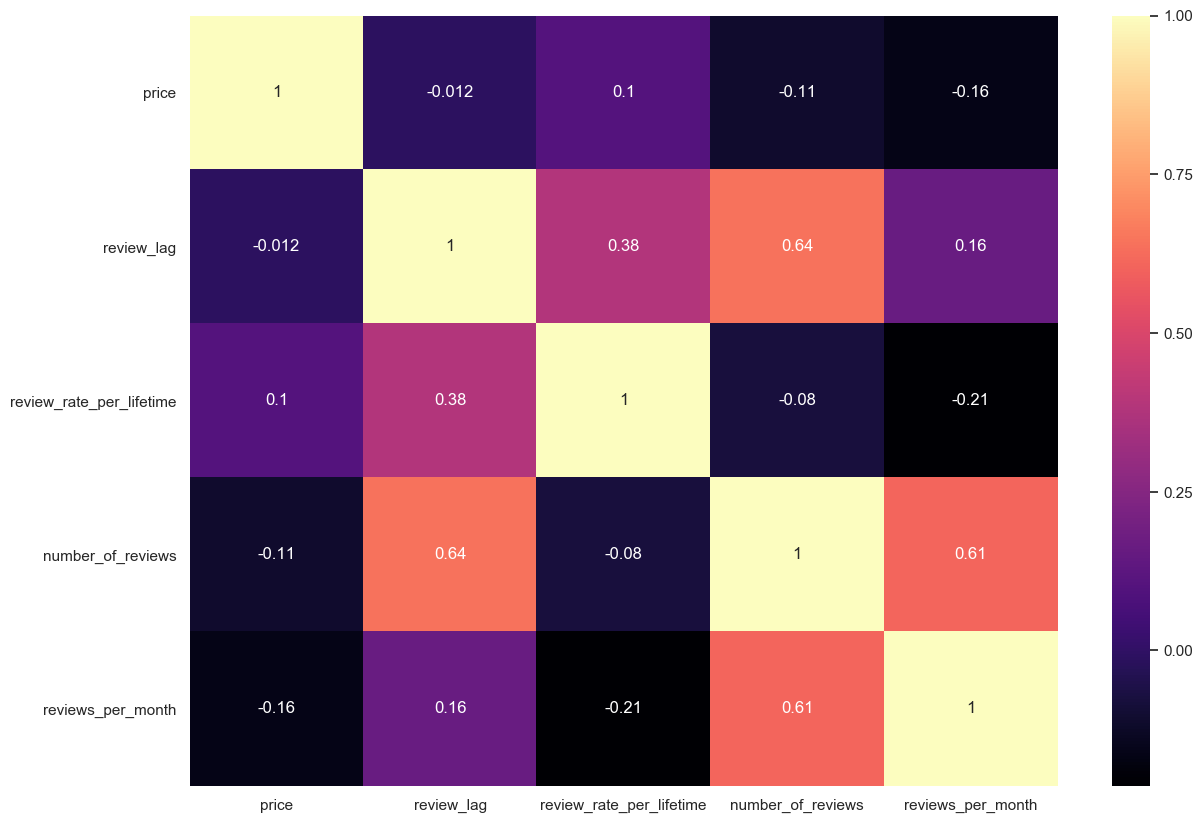

In [97]:
analysis = AnalysisStatus(df_calendar_complete, df_listings_transform)
analysis.correlation_heatmap(
    ['review_lag', 'review_rate_per_lifetime', 'number_of_reviews', 'reviews_per_month'])

**Analysis**: We are removing **first_review** and **last_review** and replacing it with **review_lag** to account for the dates between the first review and the last review. We are also engineering the rate of reviews by dividing the **review_lag** by the **number_of_reviews**, this is the **review_rate_per_lifetime**.

The **review_lag** ended up not being valuable. The **review_rate_per_lifetime** ended up being valuable, but it was less than the **number_of_reviews** from which it came. Thus, we are removing it.

We can see that the only valuable features are the **number_of_reviews** and **reviews_per_month**.

In [98]:
df_listings_transform.drop([
    'review_lag', 'review_rate_per_lifetime'
], axis=1, inplace=True)

### Removing Other Irrelevant Features

In [99]:
list_irrelevant_cols.remove('host_about')

In [100]:
possible_columns = ['host_has_profile_pic', 'require_guest_profile_picture']

# Remove irrelevant columns
drop_columns = [
    i for i in list_irrelevant_cols
    if i not in possible_columns + ['jurisdiction_names']
]

df_listings_transform.drop(drop_columns, axis=1, inplace=True)

**Analysis**: We ended up removing all irrelevant features except for  the picture related columns, which could be benefetial to the model.

### Host Acceptance and  Response Rate and Time

In [101]:
# Cleaning percentages
df_listings_transform.loc[:, 'host_acceptance_rate'] = cleaning_percent(
    df_listings_transform.host_acceptance_rate)

df_listings_transform.loc[:, 'host_response_rate'] = cleaning_percent(
    df_listings_transform.host_response_rate)

In [102]:
# Adding prefix
lmfunc_colname = lambda x: 'resp_t_' + str(x)

response_time = pd.get_dummies(
    df_listings_transform.host_response_time,
    dummy_na=True).rename(columns=lmfunc_colname)

# Extracting prefixed columns
response_time_col = response_time.columns.tolist()

In [103]:
# Add newly created dummies for response time and delete original
df_listings_transform = pd.concat([df_listings_transform, response_time],
                               axis=1).drop(
                                   'host_response_time', axis=1)

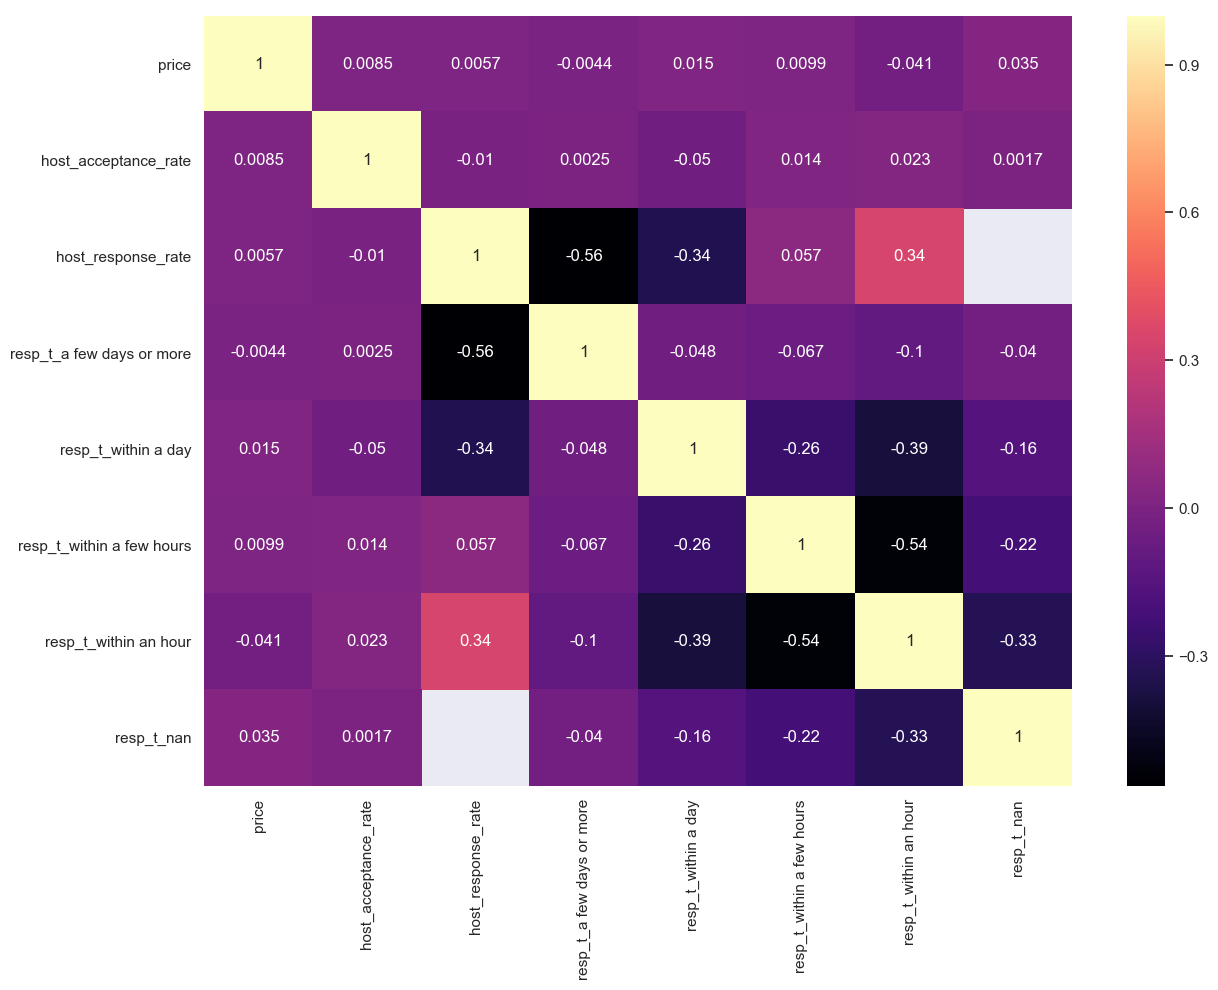

In [104]:
analysis = AnalysisStatus(df_calendar_complete, df_listings_transform)
analysis.correlation_heatmap(['host_acceptance_rate', 'host_response_rate'] +
                             response_time_col)

**Analysis**: As we can see, **host_response_time** adds little value to the model. Thus, we will remove it. Also, **host_response_rate** adds no value to the model.

In [105]:
df_listings_transform.drop(
    ['host_response_rate', 'host_acceptance_rate'] + 
    response_time_col, axis=1, inplace=True)

In [106]:
analysis.null_row_feature_status(percentages=True)

Series([], dtype: float64)

### Assessing Nulls at the Row Level

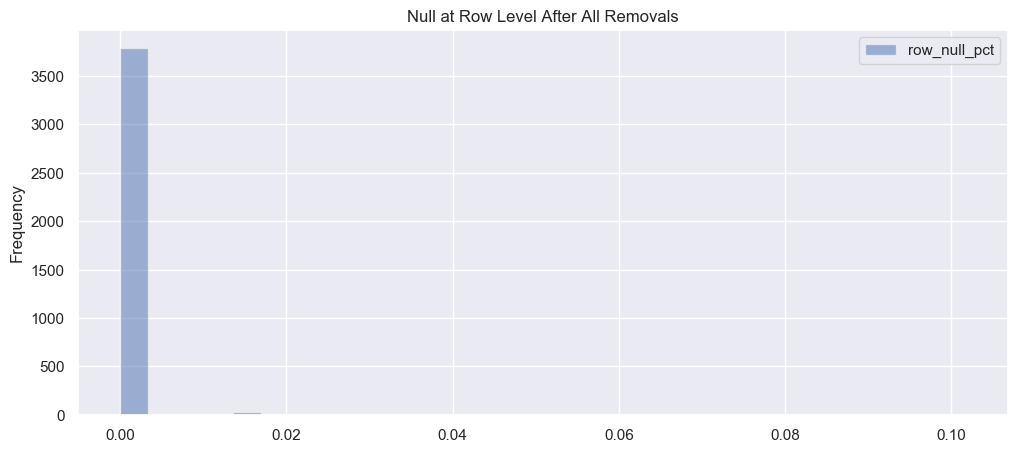

In [107]:
analysis.null_row_listingdist(30, 'Null at Row Level After All Removals')

### Splitting, Engineering, and Removing amenities and host_verifications

In [108]:
# Instantiationg encoder
# Note that DummySplit assigns the dummies in the same location in memory
# No need for assigning them to the dataframe
ds = DummySplit(df_listings_transform)

# Original example
df_listings_transform[['amenities']].head()

,amenities
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ..."
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."


In [109]:
# split add and drop -- save columns and example of transformations
ds.split_create_dummy('amenities')
ds.add_dummies(drop_original=True)
amenities_columns = ds.dummy_columns[:]
ds.dummy_frame.head()

,TV,CableTV,Internet,WirelessInternet,AirConditioning,Kitchen,Heating,FamilyKidFriendly,Washer,Dryer,...,SuitableforEvents,ElevatorinBuilding,LockonBedroomDoor,WheelchairAccessible,Gym,Pool,SmokingAllowed,Otherpets,Doorman,WasherDryer
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# Original example
df_listings_transform[['host_verifications']].head()

,host_verifications
0,"['email', 'phone', 'reviews', 'kba']"
1,"['email', 'phone', 'facebook', 'linkedin', 're..."
2,"['email', 'phone', 'google', 'reviews', 'jumio']"
3,"['email', 'phone', 'facebook', 'reviews', 'jum..."
4,"['email', 'phone', 'facebook', 'reviews', 'kba']"


In [111]:
# split add and drop -- save columns and example of transformations
ds.split_create_dummy(feature_name='host_verifications')
ds.add_dummies(drop_original=True)
host_verifications = ds.dummy_columns[:]
ds.dummy_frame.head()

,email,phone,reviews,kba,facebook,linkedin,jumio,google,manualoffline,amex,manualonline,sentid,photographer,weibo
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,1,1,0,0,0,0,0,0,0
2,1,1,1,0,0,0,1,1,0,0,0,0,0,0
3,1,1,1,0,1,0,1,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0,0,0,0,0


In [112]:
# release memory
del ds

#### Checking Correlation of New Features

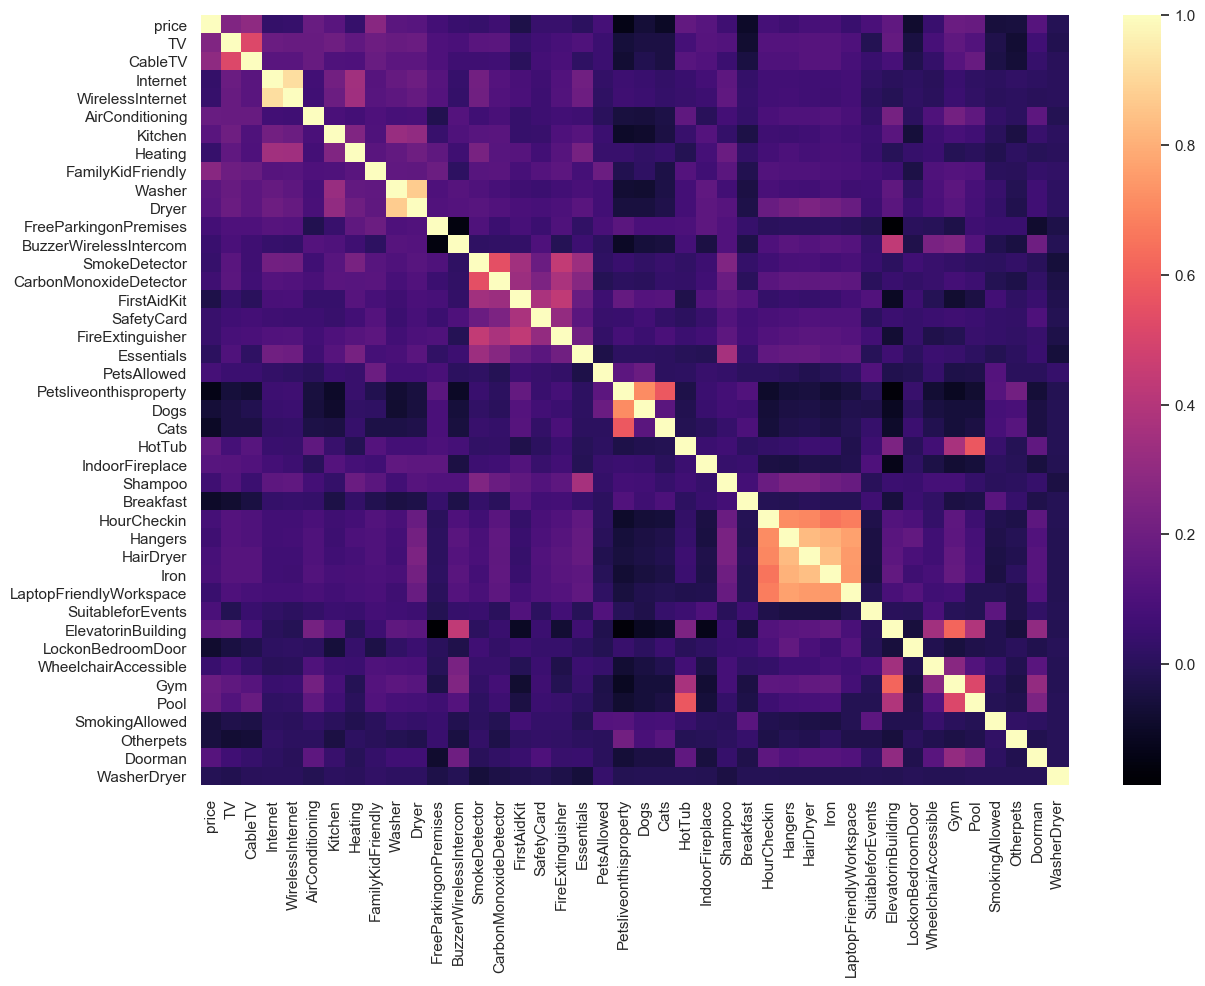

In [113]:
analysis = AnalysisStatus(df_calendar_complete, df_listings_transform)
analysis.correlation_heatmap(amenities_columns, show_values=False)

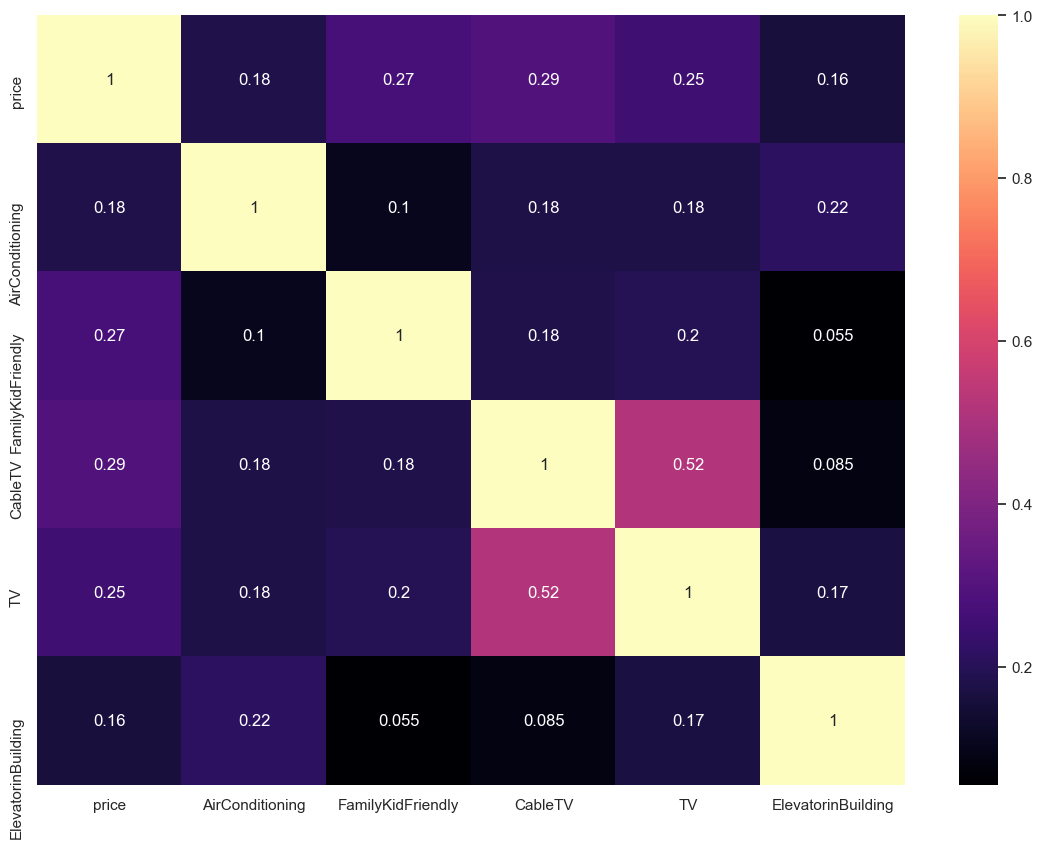

In [114]:
scope = ['AirConditioning', 'FamilyKidFriendly', 'CableTV', 'TV', 'ElevatorinBuilding']
analysis.correlation_heatmap(scope, show_values=True)

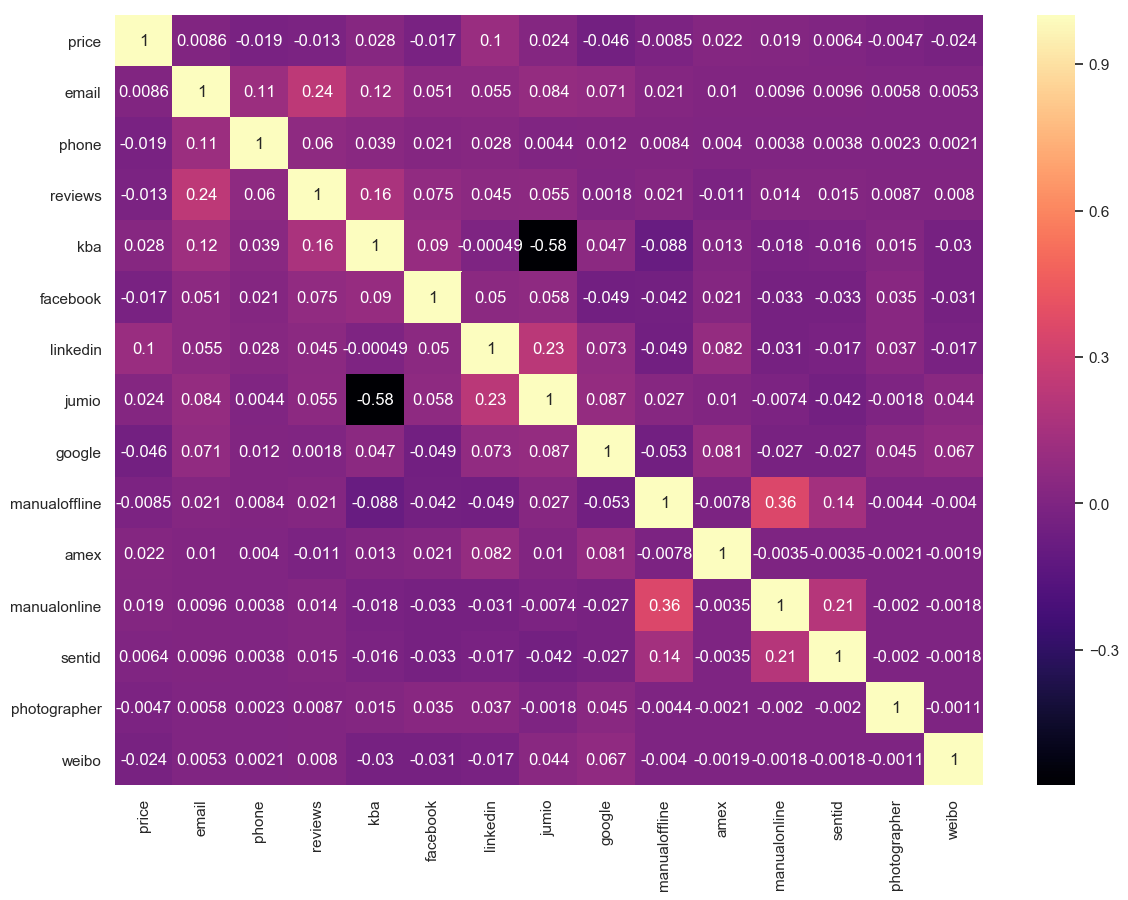

In [115]:
analysis.correlation_heatmap(host_verifications, show_values=True)

**Analysis**: The engineered dummies did end up adding value to the model. However, there are some extracted dummies that do not add value to the model. 

### Final Transformations and Removals

#### Removing Irrelevant Columns

In [116]:
removals = [
    'calendar_updated', 'experiences_offered', 'is_location_exact',
    'zipcode', 'street', 'smart_location', 'country_code'
]

df_listings_transform.drop(removals, axis=1, inplace=True)

#### Transformations of t/f Values

In [117]:
transform = [
    'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost',
    'instant_bookable', 'require_guest_phone_verification', 'requires_license',
    'require_guest_profile_picture'
]

df_listings_transform.loc[:, transform] = df_listings_transform[transform].apply(
    lambda x: x.map({
        'f': 1,
        't': 0
    }))

df_listings_transform[transform].head()

,host_has_profile_pic,host_identity_verified,host_is_superhost,instant_bookable,require_guest_phone_verification,requires_license,require_guest_profile_picture
0,0.0,0.0,1.0,1,1,1,1
1,0.0,0.0,0.0,1,0,1,0
2,0.0,0.0,1.0,1,1,1,1
3,0.0,0.0,1.0,1,1,1,1
4,0.0,0.0,1.0,1,1,1,1


#### Engieneering host_lifetime from  host_since and calendar_updated

In [118]:
engieneering = ['host_since', 'calendar_last_scraped']

# Engineering feature by subracting
host_lifetime = df_listings_transform.calendar_last_scraped.apply(
    pd.to_datetime) - df_listings_transform.host_since.apply(pd.to_datetime)

# Extracting date number
host_lifetime = host_lifetime.apply(lambda x: x.days)

# Deleting original from dataset
df_listings_transform.drop(engieneering, axis=1, inplace=True)

# Adding engineered feature to dataset
df_listings_transform['host_lifetime'] = host_lifetime

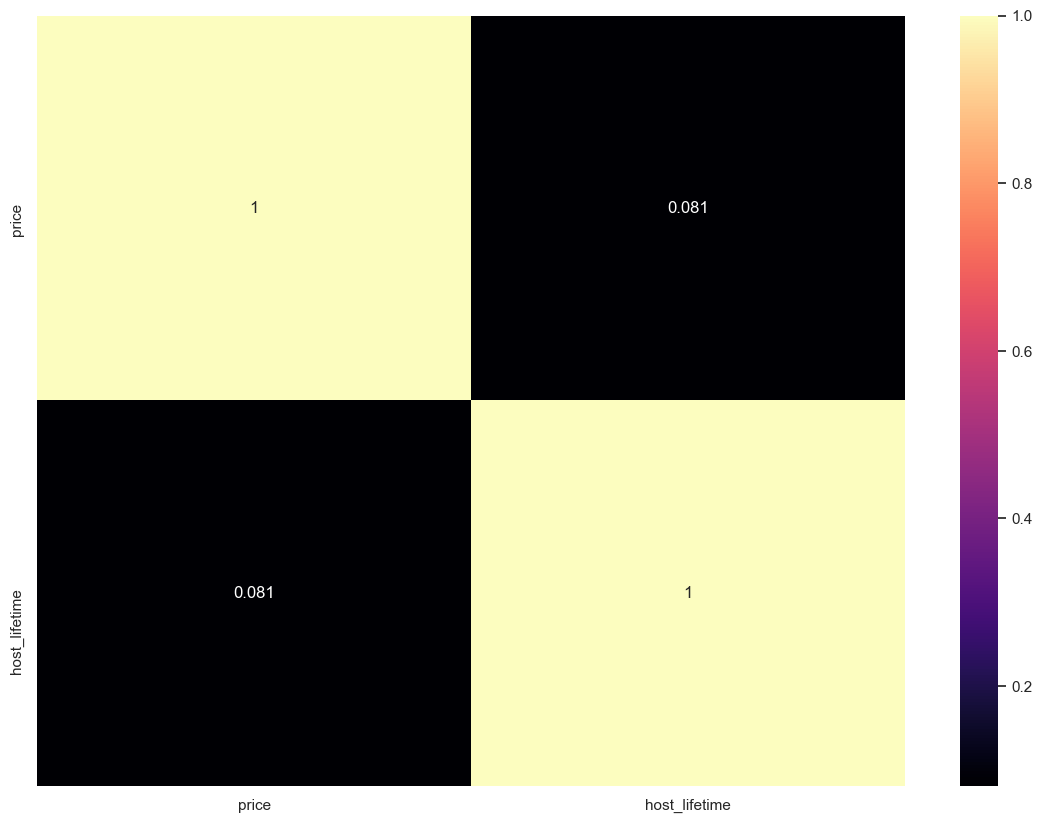

In [119]:
analysis = AnalysisStatus(df_calendar_complete, df_listings_transform)
analysis.correlation_heatmap(['host_lifetime'])

**Analysis**: A correlation of .08 is a small correlation. However, it could be beneficial to the model by a small margin. We will test the model with the highest correlated features first and will add some like this one to it to attempt to improve its scores.

## One-Hot Encoder

In [120]:
checkpoint = df_listings_transform.copy()

### Applying Encoder to Categorical

In [121]:
# Saving Categorical for further analysis
df_categorical = df_listings_transform.select_dtypes(include=object)

# Example of categorical
df_categorical.sample(2).T

,1885,1565
property_type,House,Apartment
room_type,Private room,Entire home/apt
bed_type,Real Bed,Real Bed
cancellation_policy,flexible,strict


### Applying One-Hot Encoder

In [122]:
# Initiating Encoder
encoder = OneHotEncoder()

# Get only columns with categories
listings_object = df_listings_transform.select_dtypes(
    include=object)

# Get list of removal columns
remove_original = listings_object.columns.tolist()

# Fitting and tranforming categories
# Fill nulls with missing to create missing dummy
X_encoded = encoder.fit_transform(listings_object.astype(str))

# Remove original encoded columns
df_listings_transform.drop(remove_original, axis=1, inplace=True)

# Encoded coluns
columns_encoded = encoder.categories_

# Extracting from list of list
dummy_columns = []
for original, enc_col in list(zip(remove_original, columns_encoded)):
    for dummy in enc_col:
        dummy_columns.append(re.sub('\W', '', (original + '_' + dummy)))

# Creating dataframe
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=dummy_columns)

# Applying listings 
df_listings_encoded = pd.concat([df_listings_transform, X_encoded], axis=1)

## Correlation Analysis

### Final Dataset to Assess

In [123]:
# Final Merge
analysis.listings = df_listings_encoded
analysis._merge()

### Finding Perfect Multicollinearity

In [124]:
analysis.colliniearity_table(include_perfect=True)

Processing collinearity table. Please wait a minute.


,feature,price_r,relation_to,abs_multi_r,direction
3,id,-0.050329,listing_id,1.0,+
262,listing_id,-0.050329,id,1.0,+
1322,host_total_listings_count,0.179392,host_listings_count,1.0,+
1452,host_listings_count,0.179392,host_total_listings_count,1.0,+


#### Removing Ids and features with perfect mutlcollinearity

In [125]:
analysis.df_merged.drop(
    ['id', 'listing_id', 'host_total_listings_count'], 
    axis=1, 
    inplace=True)

### Finding High Multicollinearity

In [126]:
analysis.colliniearity_table(multi_r=.8)

Processing collinearity table. Please wait a minute.


,feature,price_r,relation_to,abs_multi_r,direction
1681,beds,0.609017,accommodates,0.860067,+
2062,accommodates,0.676054,beds,0.860067,+
2176,price,1.000000,price_listing,0.911313,+
3098,availability_60,-0.001076,availability_30,0.928155,+
3099,availability_90,-0.006974,availability_30,0.861434,+
3225,availability_30,0.007134,availability_60,0.928155,+
3227,availability_90,-0.006974,availability_60,0.969661,+
3353,availability_30,0.007134,availability_90,0.861434,+
3354,availability_60,-0.001076,availability_90,0.969661,+
4904,require_guest_phone_verification,-0.078789,require_guest_profile_picture,0.867786,+


#### Bed Vs. Accommodates

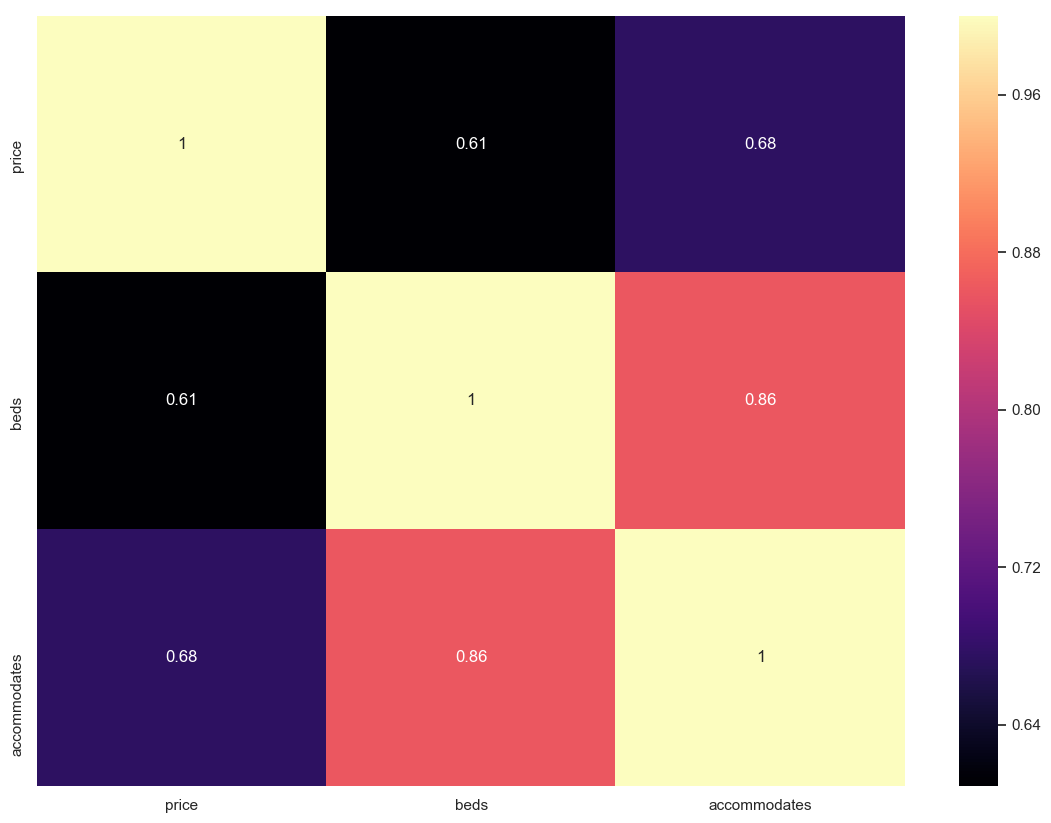

In [127]:
analysis.correlation_heatmap(['beds', 'accommodates'])

**Analysis**: We see a high indication of multicollinearity with beds and accommodates. It make sense to think that a listing with more beds accommodates more people. However, accommodates have more corellation with calendar listing price than beds. For this reason, we are removing beds from the model.

In [128]:
analysis.df_merged.drop('beds', axis=1, inplace=True)

#### Removing Price in Listing Dataset

**Analysis**: No need to analyize this. It is obvious that last sccraped price in listing will be slighly correlated with calendar listing price.

In [129]:
analysis.df_merged.drop('price_listing', axis=1, inplace=True)

#### Availability Features

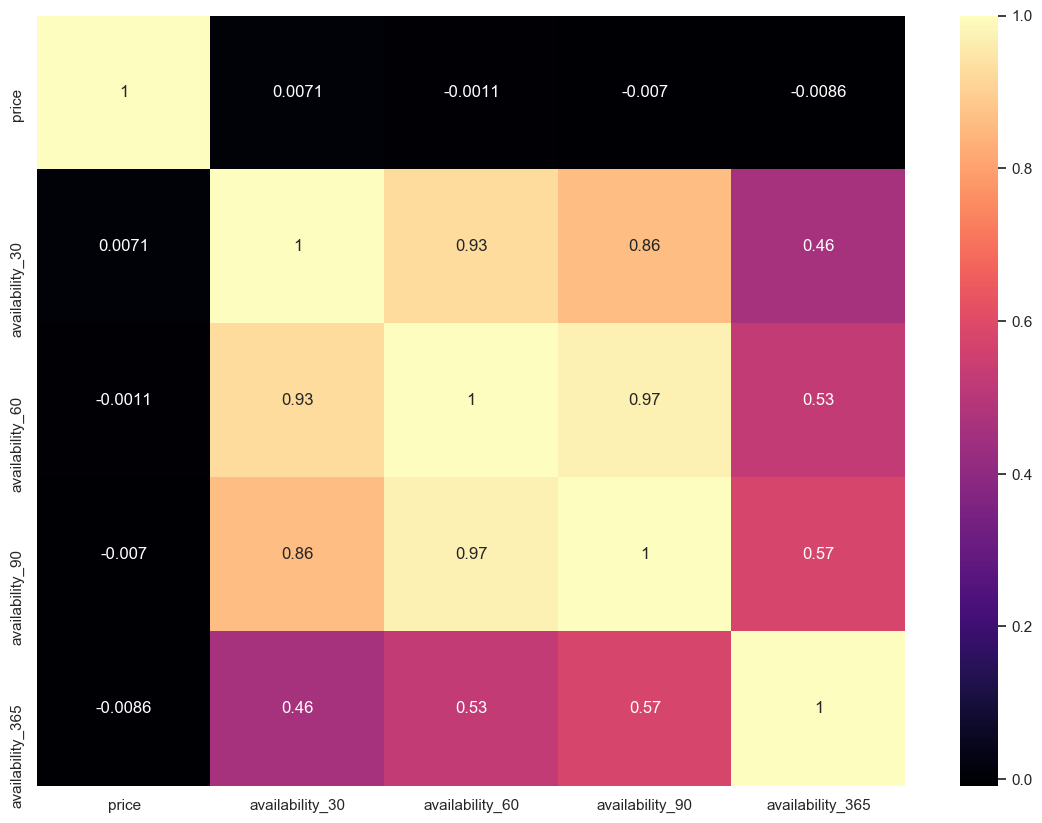

In [130]:
available_cond = analysis.df_merged.columns.str.contains('avail')
available_col = analysis.df_merged.columns[available_cond].tolist()
analysis.correlation_heatmap(available_col)

**Analysis**: All availability features are correlated with each other, except for availability_365. Nevertheless, it has an insignificant correlation with price. Thus, we are removing it. The other 3 (availability_30, availability_60, and availability_90) may be all calculated features and therefore have multicollinearity because of it. Base on the correlation with calendar listing price, we are not keeping any of them.

In [131]:
analysis.df_merged.drop(available_col, axis=1, inplace=True)

#### Host Listings Vs. Calculated Host Listings

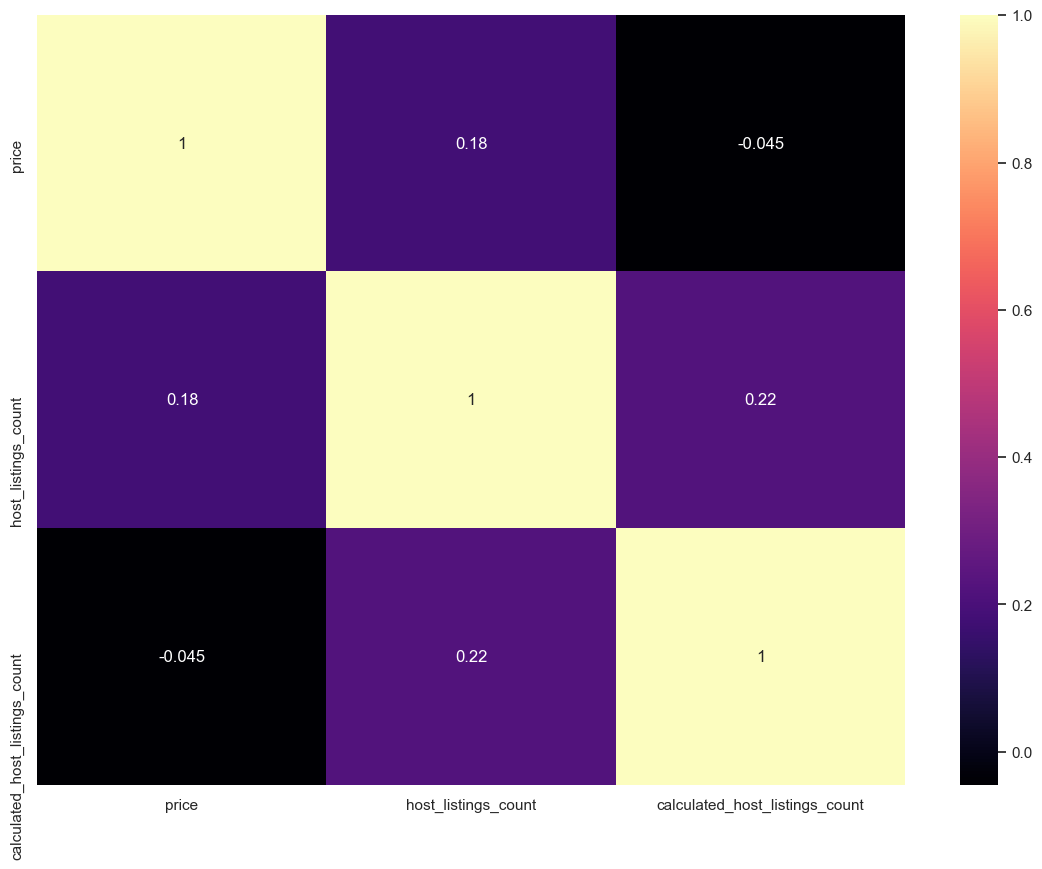

In [132]:
analysis.correlation_heatmap(['host_listings_count', 'calculated_host_listings_count'])

**Analysis**: Giving that host_listings has a calculated counterpart, we are keeping only the feature most correlated with calendar listing price, which is **host_listings**.

In [133]:
analysis.df_merged.drop('calculated_host_listings_count', axis=1, inplace=True)

#### Internet and WirelessInternet Combination

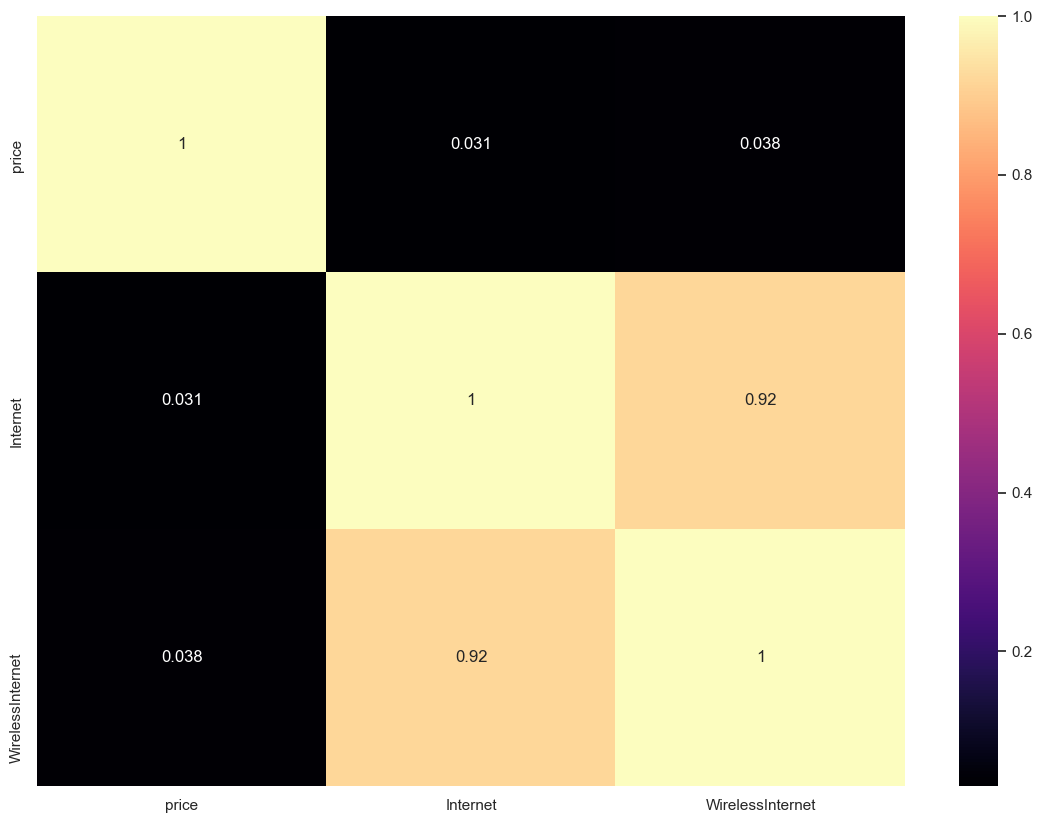

In [134]:
analysis.correlation_heatmap(['Internet', 'WirelessInternet'])

**Analysis**: They have almost the same correlation. However, removing one of them might create some bias since they mean exactly the same thing. Instead of removing it, we are just combining them into one.

The methodology is summing both dummies. If the value is zero, then no internet was provided. If not zero, then internet was provided. 

In [135]:
print("This is the original shape of the model data", analysis.df_merged.shape)

This is the original shape of the model data (934542, 121)


In [136]:
# Condensing dummie into one series
internet_condense = analysis.df_merged[['Internet', 'WirelessInternet'
                    ]].sum(axis=1).where(lambda x: x==0, 1)

internet_condense.value_counts()

1    902316
0     32226
dtype: int64

In [137]:
# Where sum of both is greater than zero, or at least one has internet
analysis.df_merged[['Internet', 'WirelessInternet'
                    ]].eval("Internet+WirelessInternet>0").value_counts()

True     902316
False     32226
dtype: int64

In [138]:
# Where there is a one on either of them, validation
analysis.df_merged.query("Internet==1 or WirelessInternet==1").shape

(902316, 121)

In [139]:
analysis.df_merged.drop('WirelessInternet', axis=1, inplace=True)

In [140]:
analysis.df_merged.loc[:, 'Internet'] = internet_condense

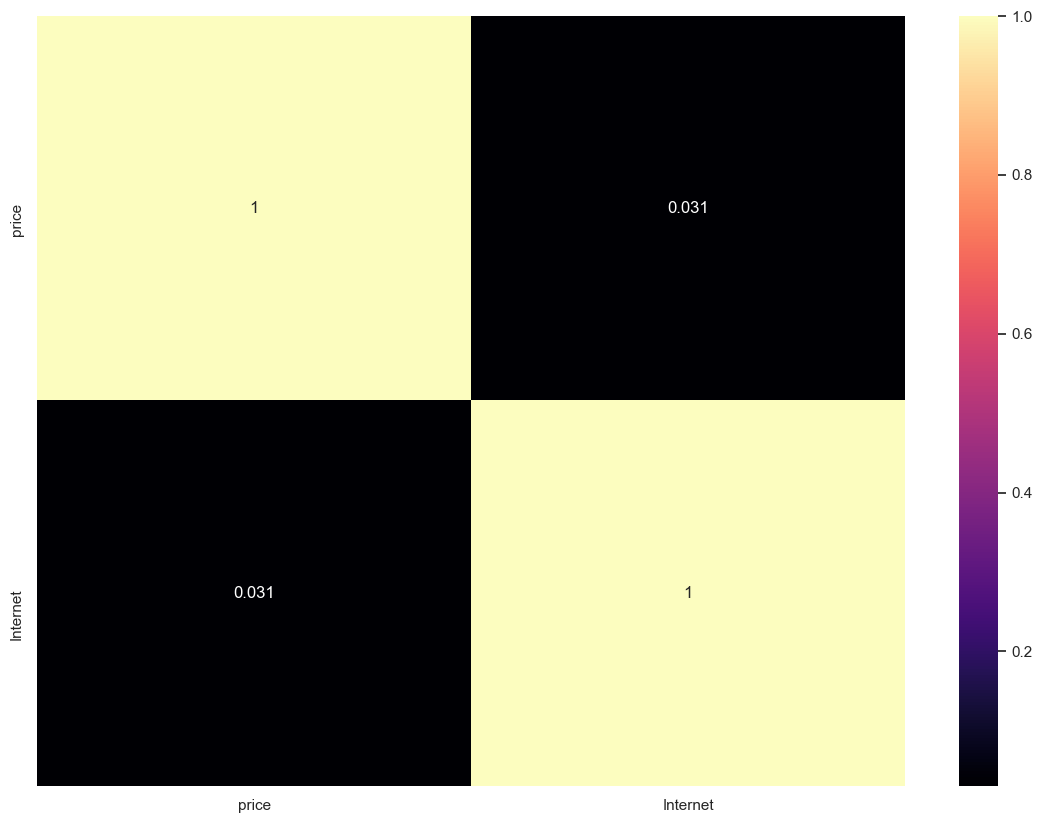

In [141]:
analysis.correlation_heatmap(['Internet'])

#### Iron and HairDryer Combination

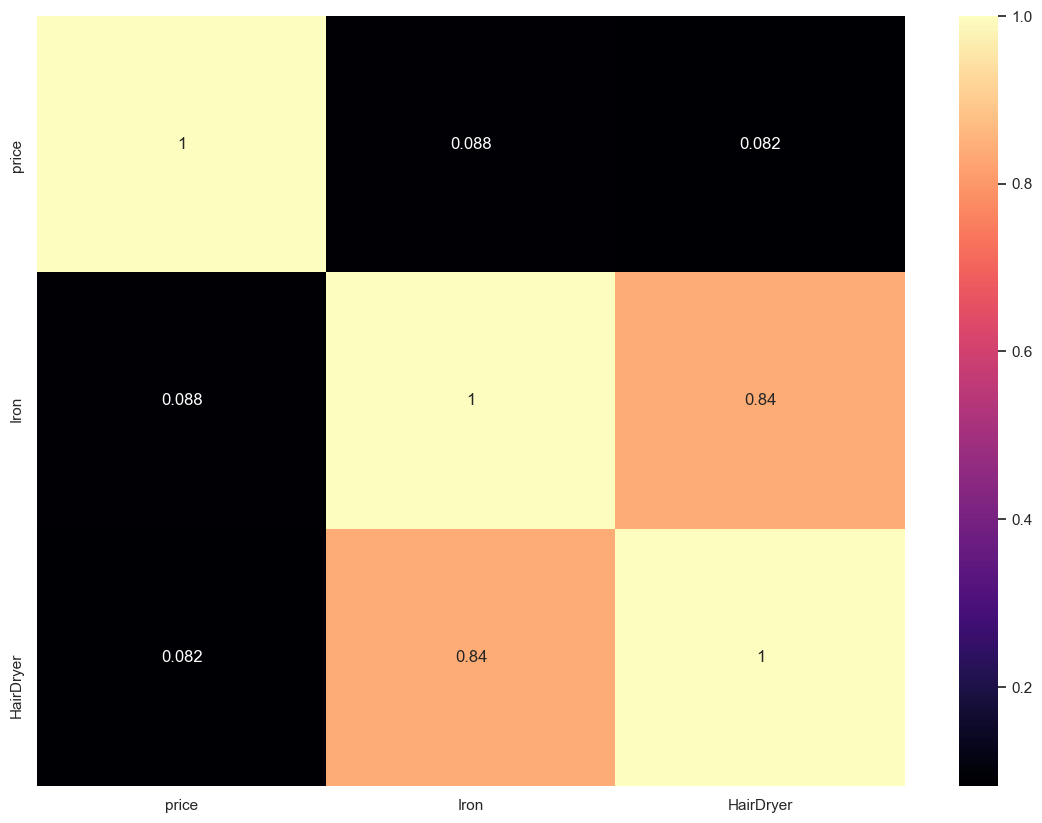

In [142]:
analysis.correlation_heatmap(['Iron', 'HairDryer'])

**Analysis**: Since these two dummy variables most likely are offered one without the other, they have a high multicollinearity. However, we could engineer a new feature called iron_hairdryer to see if it performs better than the individual ones.

The methodology of the new feature (iron_hairdryer) is if the sum of both is 2, then they provided both iron and hair dryer--we set it to 1. If the sum is not 2, then they did not provided the combo and therefore is set to 0.

In [143]:
# Combining into one series
combination_ind = analysis.df_merged[[
    'Iron', 'HairDryer'
]].sum(axis=1).where(lambda x: x == 0, 1)

combination_ind.value_counts()

0    732439
1    202103
dtype: int64

In [144]:
# Where sum of both is greater than zero, or at least one has internet
analysis.df_merged[['Iron', 'HairDryer'
                    ]].eval("Iron+HairDryer>0").value_counts()

False    732439
True     202103
dtype: int64

In [145]:
# Where there is a one on either of them, validation
analysis.df_merged.query("Iron==1 or HairDryer==1").shape

(202103, 120)

In [146]:
analysis.df_merged.loc[:, 'iron_hairdryer'] = combination_ind

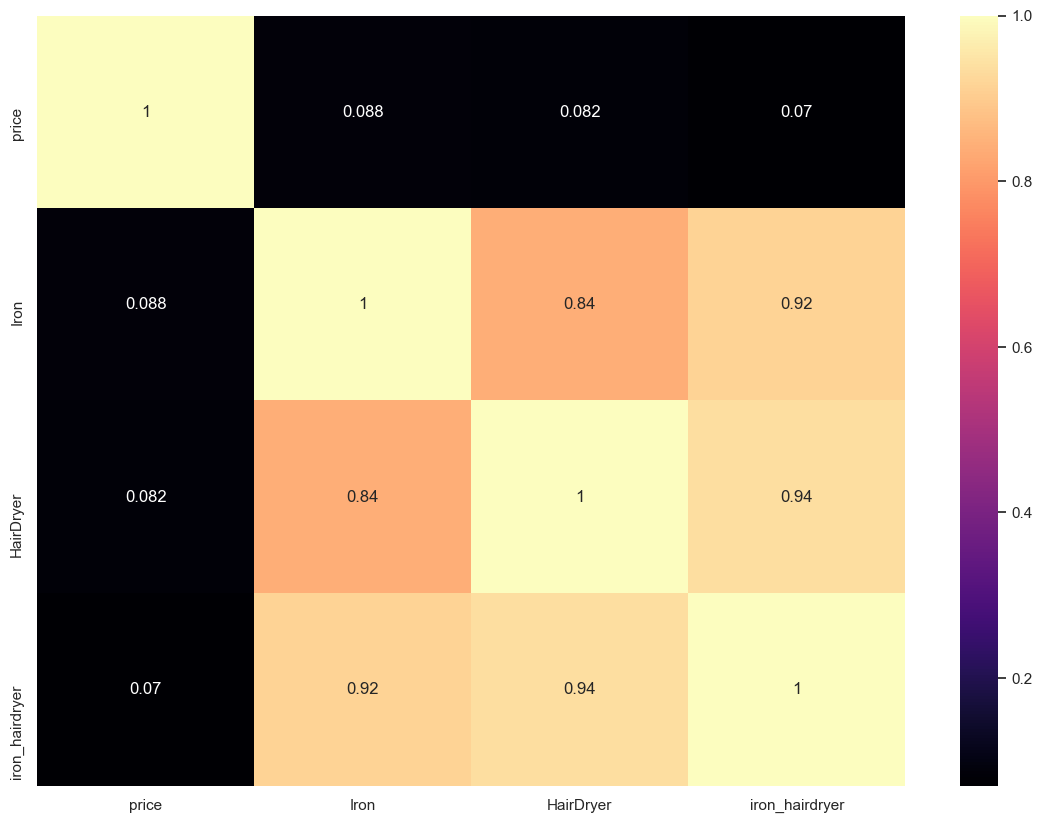

In [147]:
analysis.correlation_heatmap(['Iron', 'HairDryer', 'iron_hairdryer'])

**Analysis**: Unexpected, but the combination of both did not added value to the model. We will only keep Iron for the analysis. 

In [148]:
analysis.df_merged.drop(['iron_hairdryer', 'HairDryer'], axis=1, inplace=True)

#### Private Room, Apartment, Entire Home, and House

In [149]:
analysis.colliniearity_table(multi_r=.8)

Processing collinearity table. Please wait a minute.


,feature,price_r,relation_to,abs_multi_r,direction
3842,require_guest_phone_verification,-0.078789,require_guest_profile_picture,0.867786,+
3960,require_guest_profile_picture,-0.080331,require_guest_phone_verification,0.867786,+
5162,Dryer,0.128145,Washer,0.872190,+
5280,Washer,0.138511,Dryer,0.872190,+
7442,Iron,0.087812,Hangers,0.809601,+
7560,Hangers,0.061150,Iron,0.809601,+
10810,property_type_House,-0.011738,property_type_Apartment,0.823625,-
11872,property_type_Apartment,0.011220,property_type_House,0.823625,-
12842,room_type_Privateroom,-0.389643,room_type_Entirehomeapt,0.921107,-
12960,room_type_Entirehomeapt,0.445755,room_type_Privateroom,0.921107,-


In [150]:
analysis.df_merged.drop('require_guest_phone_verification', axis=1, inplace=True)

**Analysis**: require_guest_phone_verification is less correlated with price.

#### Dryer Vs. Washer

In [151]:
analysis.df_merged['Dryer_and_Washer'] = analysis.df_merged[
    ['Dryer', 'Washer']].sum(axis=1).map({1:0, 2:1})

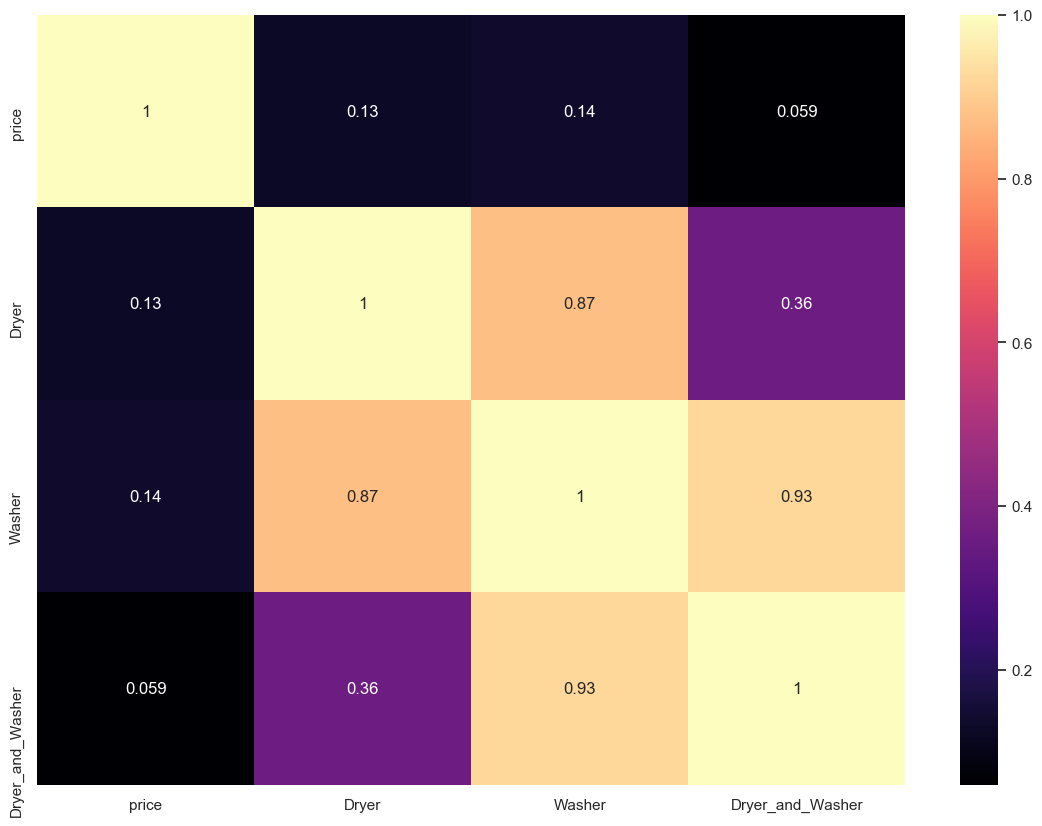

In [152]:
analysis.correlation_heatmap(['Dryer', 'Washer', 'Dryer_and_Washer'])

**Analysis**: The combination of dryer and washer is not more valuable than having either a Dryer or a Washer. So we are removing **Dryer and Dryer_and_Washer**.

In [153]:
analysis.df_merged.drop(['Dryer', 'Dryer_and_Washer'], axis=1, inplace=True)

#### Iron Vs. Hanger

In [154]:
analysis.df_merged.drop('Hangers', axis=1, inplace=True)

**Analysis**: We are dropping hangers because it is less valuable than Iron.

In [155]:
analysis.colliniearity_table(multi_r=.8)

Processing collinearity table. Please wait a minute.


,feature,price_r,relation_to,abs_multi_r,direction
10189,property_type_House,-0.011738,property_type_Apartment,0.823625,-
11224,property_type_Apartment,0.011220,property_type_House,0.823625,-
12170,room_type_Privateroom,-0.389643,room_type_Entirehomeapt,0.921107,-
12285,room_type_Entirehomeapt,0.445755,room_type_Privateroom,0.921107,-


#### Apartment Vs. House

In [156]:
list_house_apt = analysis.df_merged.filter(regex='House|Apartment').columns.tolist()

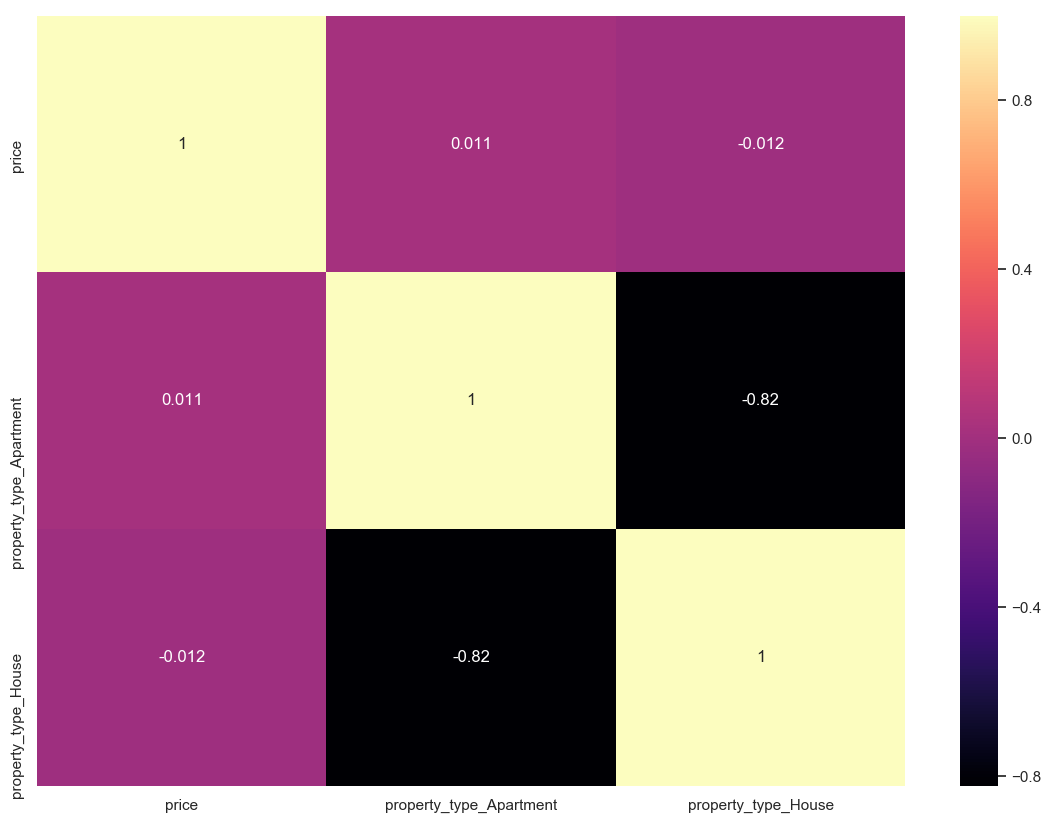

In [157]:
analysis.correlation_heatmap(list_house_apt, show_values=True)

**Analysis**: They are both shortly valuable. However, we are removing apartment because house is more correlated with price.

In [158]:
analysis.df_merged.drop('property_type_Apartment', axis=1, inplace=True)

#### Private Room Vs. Entire Home Apt

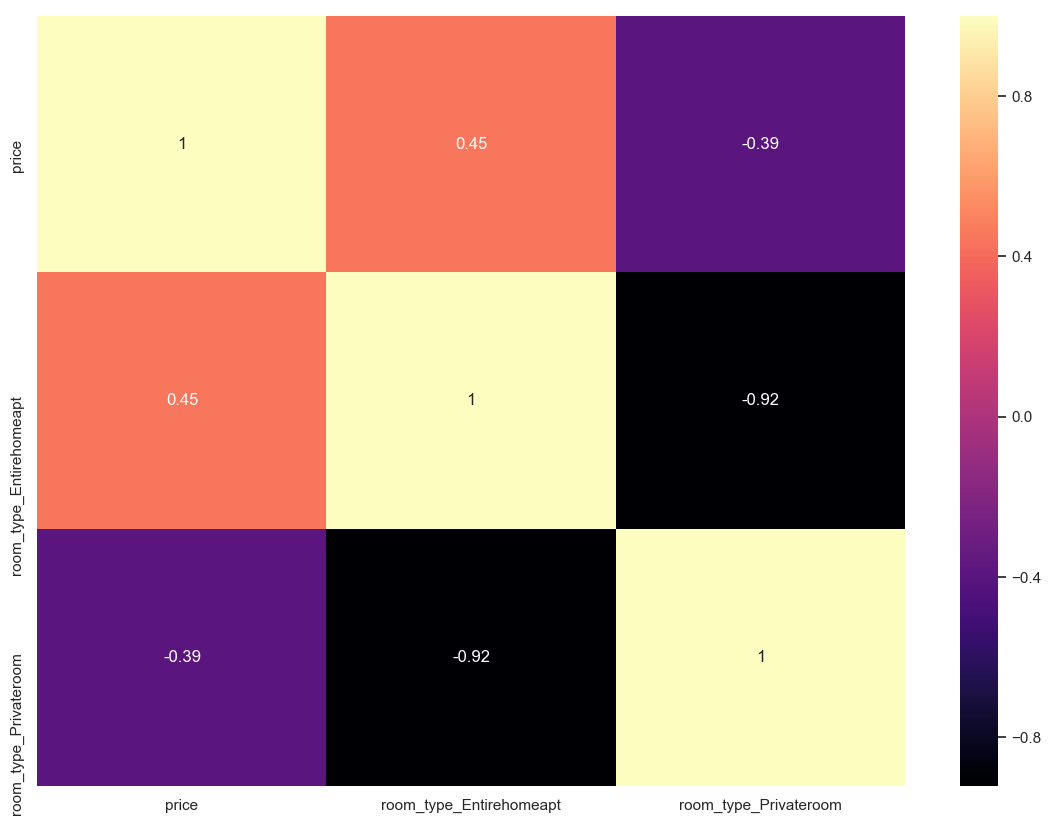

In [159]:
list_priv_ent = analysis.df_merged.filter(regex='Private|Entire').columns.tolist()
analysis.correlation_heatmap(list_priv_ent)

**Analysis**: These are very valuable features. However, because of their mutlicollinearity, we will remove private room indicators.

In [160]:
analysis.df_merged.drop('room_type_Privateroom', axis=1, inplace=True)

### Remove Final Nulls

In [161]:
(analysis.df_merged.isnull().sum()/analysis.df_merged.shape[0]).where(lambda x: x>0).dropna()

host_is_superhost         0.000098
host_listings_count       0.000098
host_has_profile_pic      0.000098
host_identity_verified    0.000098
bathrooms                 0.005139
bedrooms                  0.002143
host_lifetime             0.000098
dtype: float64

**Analysis**: Given that the null values in the final frame is miniscule, we are safe to remove all of these values.

In [162]:
analysis.df_merged.dropna(inplace=True)

### Finalizing the Data

In [163]:
df_airbnb = analysis.df_merged
#del analysis

In [164]:
# Dropping the count of nulls
df_airbnb.drop('row_null_pct', axis=1, inplace=True)

#### Removing Less than .01 Collinearity

In [165]:
df_airbnb.rename(columns={'date_num': 'date'}, inplace=True)
df_airbnb = get_top_collinearity(df_airbnb, show_top10=True)

,price
accommodates,0.676042
bedrooms,0.632605
cleaning_fee,0.625462
bathrooms,0.525835
room_type_Entirehomeapt,0.446458
guests_included,0.387881
security_deposit,0.335759
CableTV,0.295362
cancellation_policy_strict,0.274924
FamilyKidFriendly,0.272994


### Variance Inflation Factor (VIF)

In [166]:
vif_factors = vif(df_airbnb)

### Variance Factor Inflator Greater than 5

In [167]:
high_vif = vif_factors.sort_values(ascending=False).where(lambda x: x>5).dropna()
high_vif

cancellation_policy_moderate    inf
cancellation_policy_flexible    inf
cancellation_policy_strict      inf
dtype: float64

**Analysis**: We are removing all features with a high VIF. They have too much multicollinearity.

In [168]:
df_airbnb = df_airbnb.drop(high_vif.index, axis=1)

### Time Series Cross Validation 

In [169]:
df_airbnb.columns

Index(['price', 'date', 'accommodates', 'bedrooms', 'cleaning_fee',
       'bathrooms', 'room_type_Entirehomeapt', 'guests_included',
       'security_deposit', 'CableTV', 'FamilyKidFriendly', 'TV', 'Gym',
       'AirConditioning', 'host_listings_count', 'Pool',
       'room_type_Sharedroom', 'HotTub', 'reviews_per_month',
       'ElevatorinBuilding', 'Washer', 'Petsliveonthisproperty', 'Kitchen',
       'IndoorFireplace', 'Doorman', 'bed_type_RealBed', 'number_of_reviews',
       'extra_people', 'longitude', 'Cats', 'linkedin', 'Breakfast',
       'SuitableforEvents', 'property_type_Boat', 'bed_type_Futon', 'Iron',
       'LockonBedroomDoor', 'review_scores_location', 'host_lifetime',
       'require_guest_profile_picture', 'FreeParkingonPremises', 'HourCheckin',
       'PetsAllowed', 'review_scores_rating', 'review_scores_cleanliness',
       'Dogs', 'Shampoo', 'CarbonMonoxideDetector', 'SmokingAllowed',
       'bed_type_PulloutSofa', 'Otherpets'],
      dtype='object')

In [170]:
# Ordering dataset chronologically
df_airbnb = df_airbnb.sort_values('date')

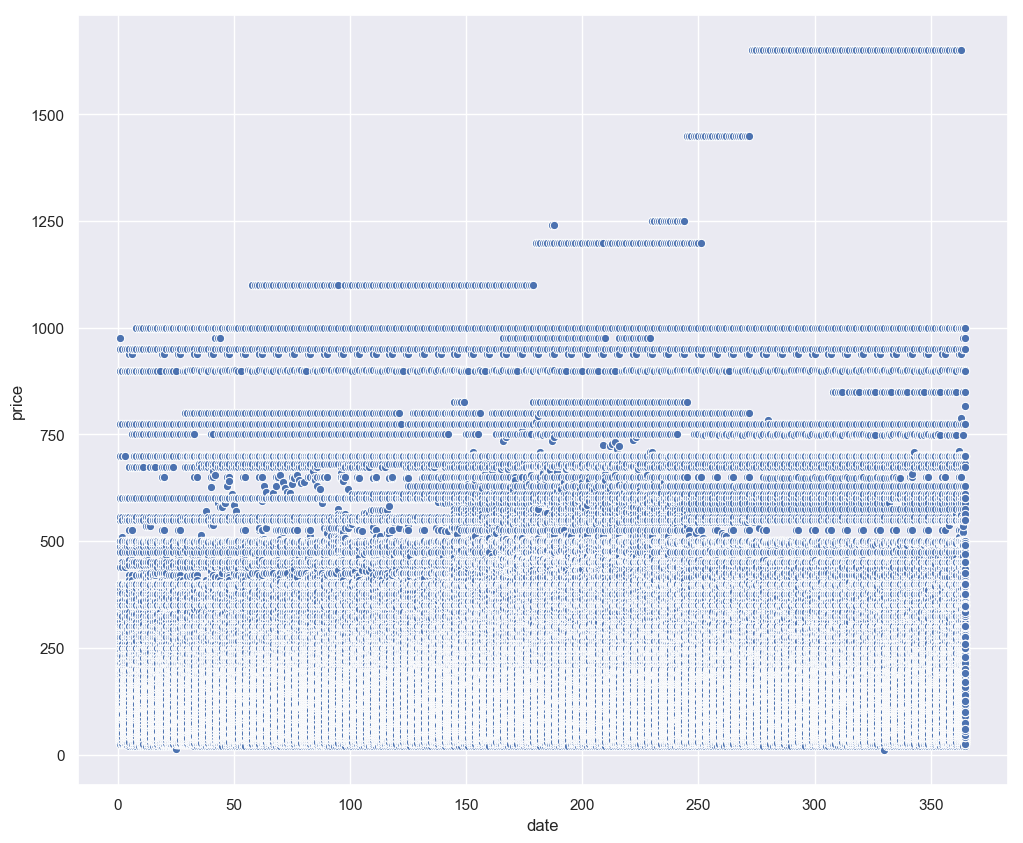

In [171]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x='date', y='price', data=df_airbnb);

# Applying Models

In [172]:
models = apply_regression_models(df_airbnb, 'price')

SPLIT 1: TRAIN 0 to 231910 or 25.00% | TEST 231911 to 463821 or 25.00%
----------------------------------------------------------------------
	Model: Linear Regression
	Coefficient of Determinaion: 61.55% 
	Mean Squared Errors: 4,395.99 
	Durbin-Watson: 2.0
----------------------------------------------------------------------
	Model: Random Forest Regressor
	Coefficient of Determinaion: 89.18% 
	Mean Squared Errors: 1,236.59 
	Durbin-Watson: 1.8
______________________________________________________________________
SPLIT 2: TRAIN 0 to 463821 or 50.00% | TEST 463822 to 695732 or 25.00%
----------------------------------------------------------------------
	Model: Linear Regression
	Coefficient of Determinaion: 62.76% 
	Mean Squared Errors: 4,897.50 
	Durbin-Watson: 1.9
----------------------------------------------------------------------
	Model: Random Forest Regressor
	Coefficient of Determinaion: 90.12% 
	Mean Squared Errors: 1,299.33 
	Durbin-Watson: 1.9
___________________________

In [175]:
models

{'LinearModel': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 'EnsembleModel': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False)}

## Linear Coefficients

In [176]:
linear = models.get('LinearModel')

linear_coefficients = pd.concat([pd.Series(linear.coef_[0]), 
           pd.Series(df_airbnb.drop('price', axis=1).columns)], axis=1)

linear_coefficients.columns = ['coefficients', 'feature_name']

linear_coefficients.sort_values('coefficients', ascending=False)

,coefficients,feature_name
32,141.911123,property_type_Boat
5,33.887110,room_type_Entirehomeapt
4,32.296384,bathrooms
2,26.335515,bedrooms
18,26.192854,ElevatorinBuilding
23,24.640374,Doorman
12,13.213751,AirConditioning
14,12.236272,Pool
1,10.718876,accommodates
11,8.708033,Gym


## Ensemble Important Factors

In [177]:
ensemble = models.get('EnsembleModel')

feature_importance = pd.concat([pd.Series(ensemble.feature_importances_), 
           pd.Series(df_airbnb.drop('price', axis=1).columns)], axis=1)

feature_importance.columns = ['importance_factor', 'feature_name']

feature_importance.sort_values('importance_factor', ascending=False)

,importance_factor,feature_name
2,0.381226,bedrooms
4,0.150576,bathrooms
3,0.057924,cleaning_fee
0,0.051436,date
5,0.048018,room_type_Entirehomeapt
27,0.031059,longitude
37,0.026147,host_lifetime
36,0.025507,review_scores_location
17,0.025502,reviews_per_month
26,0.022866,extra_people


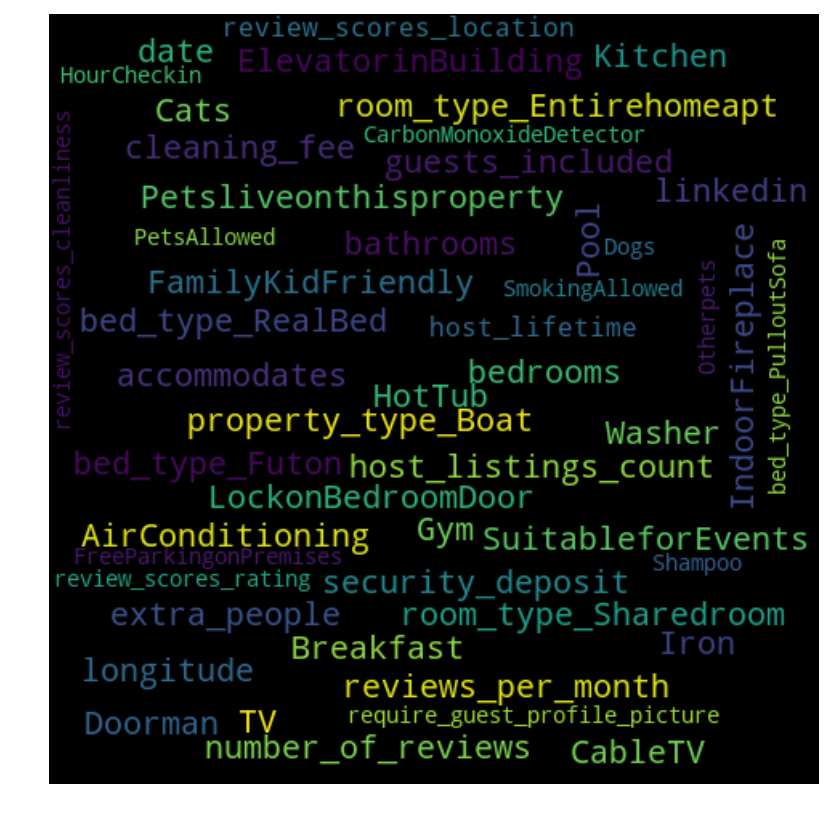

In [181]:
get_word_cloud(list(feature_importance.feature_name))